# Data Challenge

## Chicago Bike Sharing

Determine the effect of temperature on:
- bike trip counts
- bike trip lengths

controlling for any relevant seasonality (at the most relevant timescales) and customer segments.

Make your case with the appropriate visualizations.


## Data & Features

What is the data and what are the features?
- __trip_id:__              int64
- __usertype:__             object
- __gender:__               object
- __starttime:__            datetime64[ns]
- __stoptime:__             datetime64[ns]
- __tripduration:__         int64
- __from_station_id:__      int64
- __from_station_name:__    object
- __latitude_start:__       float64
- __longitude_start:__      float64
- __dpcapacity_start:__     float64
- __to_station_id:__        int64
- __to_station_name:__      object
- __latitude_end:__         float64
- __longitude_end:__        float64
- __dpcapacity_end:__       float64
- __temperature:__          float64
- __windchill:__            float64
- __dewpoint:__             float64
- __humidity:__             float64
- __pressure:__             float64
- __visibility:__           float64
- __wind_speed:__           float64
- __precipitation:__        float64
- __events:__               object
- __rain:__                 int64
- __conditions:__           object

## Approach

High level - what was your approach?
- Data Cleaning
    - check for duplicates
    - impute missing values
    - feature engineering of the start datetime
    - make everything a numerical values
- Data Analysis
    - Understand trends in the data to identify user segments
    - Understand trends in the data to identify seasonality effects
- Effect of Temperature on Customers vs Subscribers
    - Commuters vs Leisure riders

# Setup

## Import packages

Import all necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import re
import pandas_profiling as pp
from pivottablejs import pivot_ui
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


In [2]:
# import data from csv
filename = 'data_raw.csv'
df_raw = pd.read_csv(filename,
                    sep=',',
                    header='infer',
                    parse_dates=["starttime","stoptime"]
                    )

I want to be able to see all the columns, since we have ~30 columns (not very very high), I will show all the columns

In [3]:
pd.options.display.max_columns = None

In [4]:
df_raw.head()

,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,temperature,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,events,rain,conditions
0,4118,Customer,NaN,2013-06-27 12:11:00,2013-06-27 12:16:00,316,85,Michigan Ave & Oak St,41.90096,-87.623777,15.0,28,Larrabee St & Menomonee St,41.914680,-87.643320,15.0,87.1,-999.0,69.1,55.0,29.75,10.0,13.8,-9999.0,mostlycloudy,0,Mostly Cloudy
1,4095,Subscriber,Male,2013-06-27 12:06:00,2013-06-27 12:11:00,301,85,Michigan Ave & Oak St,41.90096,-87.623777,15.0,85,Michigan Ave & Oak St,41.900960,-87.623777,15.0,87.1,-999.0,69.1,55.0,29.75,10.0,13.8,-9999.0,mostlycloudy,0,Mostly Cloudy
2,4192,Subscriber,Male,2013-06-27 12:15:00,2013-06-27 12:16:00,60,28,Larrabee St & Menomonee St,41.91468,-87.643320,15.0,28,Larrabee St & Menomonee St,41.914680,-87.643320,15.0,87.1,-999.0,69.1,55.0,29.75,10.0,13.8,-9999.0,mostlycloudy,0,Mostly Cloudy
3,4275,Customer,NaN,2013-06-27 14:44:00,2013-06-27 14:45:00,64,32,Racine Ave & Congress Pkwy,41.87464,-87.657030,19.0,32,Racine Ave & Congress Pkwy,41.874640,-87.657030,19.0,89.1,-999.0,64.0,43.0,29.73,10.0,17.3,-9999.0,partlycloudy,0,Scattered Clouds
4,4291,Customer,NaN,2013-06-27 14:58:00,2013-06-27 15:05:00,433,32,Racine Ave & Congress Pkwy,41.87464,-87.657030,19.0,19,Loomis St & Taylor St,41.869417,-87.660996,15.0,89.1,-999.0,64.0,43.0,29.73,10.0,17.3,-9999.0,partlycloudy,0,Scattered Clouds


From viewing the first 5 rows, we have a number of entries that are -999 / -9999 for windchill and precipiation

We also have a number of 'NaN' for gender, specifically next to customer

In [5]:
df_raw.describe()

,trip_id,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,windchill,dewpoint,humidity,pressure,visibility,wind_speed,precipitation,rain
count,1.377472e+07,1.377472e+07,1.377472e+07,1.377356e+07,1.377356e+07,1.377356e+07,1.377472e+07,1.377354e+07,1.377354e+07,1.377354e+07,1.377472e+07,1.377472e+07,1.377472e+07,1.377380e+07,1.377472e+07,1.377472e+07,1.377472e+07,1.377472e+07,1.377472e+07
mean,9.087921e+06,1.008850e+03,1.716233e+02,4.189906e+01,-8.764150e+01,2.211155e+01,1.717968e+02,4.189951e+01,-8.764161e+01,2.208462e+01,6.469147e+01,-8.547086e+02,4.865292e+01,5.887791e+01,2.676514e+01,7.915967e+00,7.199283e+00,-9.315680e+03,3.111651e-02
std,5.025109e+06,1.900591e+03,1.212388e+02,3.404638e-02,2.216130e-02,8.443849e+00,1.214294e+02,3.419141e-02,2.226233e-02,8.454352e+00,8.111245e+01,3.566845e+02,8.349890e+01,1.696895e+01,1.800677e+02,1.309465e+02,1.759217e+02,2.523014e+03,1.736326e-01
min,3.940000e+03,6.000000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00,-9.999000e+03,-9.990000e+02,-9.999000e+03,1.300000e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00
25%,4.857076e+06,4.150000e+02,7.300000e+01,4.188096e+01,-8.765311e+01,1.500000e+01,7.300000e+01,4.188096e+01,-8.765350e+01,1.500000e+01,5.590000e+01,-9.990000e+02,3.990000e+01,4.600000e+01,2.989000e+01,1.000000e+01,6.900000e+00,-9.999000e+03,0.000000e+00
50%,9.255393e+06,7.150000e+02,1.520000e+02,4.189186e+01,-8.763851e+01,1.900000e+01,1.500000e+02,4.189228e+01,-8.763851e+01,1.900000e+01,6.980000e+01,-9.990000e+02,5.200000e+01,5.800000e+01,3.000000e+01,1.000000e+01,1.040000e+01,-9.999000e+03,0.000000e+00
75%,1.345958e+07,1.194000e+03,2.580000e+02,4.191831e+01,-8.762629e+01,2.700000e+01,2.590000e+02,4.191844e+01,-8.762629e+01,2.700000e+01,7.810000e+01,-9.990000e+02,6.100000e+01,7.100000e+01,3.011000e+01,1.000000e+01,1.380000e+01,-9.999000e+03,0.000000e+00
max,1.753670e+07,8.639900e+04,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01,9.610000e+01,4.520000e+01,7.810000e+01,1.000000e+02,3.083000e+01,1.000000e+01,4.260000e+01,8.700000e-01,1.000000e+00


Trip count:
- We have a LOT of rows: 1.38 million entries!
- From 27th June 2013 to 1st October 2017 (~1500 days)
- __approximately 9k trips per day__

Trip Duration:
- The mean trip is approximately __17 minutes__ long
- The median trip is __12 minutes__ long
- Therefore the data is positively skewed
- The longest trip duration is 1 second less than 1 full day, 24x60x60, so I assume any ride more than 1 day is capped at one day

Temperature:
- Varies from -9999 to 96.1
- -9999 is not a real temperature and likely is a result of missing data, so will need to be imputed appropriately (this is the case for all the weather data, except humidity)

For these numerical features, (relatively speaking) we don't have many missing values, only a few for humidity, dpcapacity (start + end), longitude (start + end), latitude (start + end)

## Check for Duplicates

In [6]:
number_duplicate_rows = df_raw.duplicated().value_counts().loc[True]
percent_duplicate_rows = number_duplicate_rows / len(df_raw.index) * 100
print('%d rows (%.2f %%) are duplicates' %(number_duplicate_rows, percent_duplicate_rows))



61 rows (0.00 %) are duplicates


Each row should have a unique trip_id, so I will drop the duplicate rows

In [7]:
# drop duplicates of rows, just keeping one row
df_raw = df_raw.drop_duplicates(subset=None, keep="first", inplace=False)

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13774654 entries, 0 to 13774714
Data columns (total 27 columns):
trip_id              int64
usertype             object
gender               object
starttime            datetime64[ns]
stoptime             datetime64[ns]
tripduration         int64
from_station_id      int64
from_station_name    object
latitude_start       float64
longitude_start      float64
dpcapacity_start     float64
to_station_id        int64
to_station_name      object
latitude_end         float64
longitude_end        float64
dpcapacity_end       float64
temperature          float64
windchill            float64
dewpoint             float64
humidity             float64
pressure             float64
visibility           float64
wind_speed           float64
precipitation        float64
events               object
rain                 int64
conditions           object
dtypes: datetime64[ns](2), float64(14), int64(5), object(6)
memory usage: 2.9+ GB


## Impute Missing Values


We saw in the weather data a number of -9999 / -999 values, which are missing values, so I will convert them to NaN and calculate the amount of missing values in the data

In [9]:
missing_dict = {-9999.0: np.nan, -999.0: np.nan}
df_raw = df_raw.replace(to_replace=missing_dict)

In [10]:
# how much of the data is missing in each column
def percent_missing(df):
    """
    Given a dataframe it calculates the percentage of missing records per column
    Params:
        - df
    Returns:
        - Dictionary of column name and percentage of missing records
    """
    col=list(df.columns)
    perc=[round(df[c].isna().mean()*100,2) for c in col]
    miss_dict=dict(zip(col,perc))
    return miss_dict

In [11]:
percent_missing(df_raw)

{'trip_id': 0.0,
 'usertype': 0.0,
 'gender': 27.27,
 'starttime': 0.0,
 'stoptime': 0.0,
 'tripduration': 0.0,
 'from_station_id': 0.0,
 'from_station_name': 0.0,
 'latitude_start': 0.01,
 'longitude_start': 0.01,
 'dpcapacity_start': 0.01,
 'to_station_id': 0.0,
 'to_station_name': 0.0,
 'latitude_end': 0.01,
 'longitude_end': 0.01,
 'dpcapacity_end': 0.01,
 'temperature': 0.01,
 'windchill': 85.93,
 'dewpoint': 0.01,
 'humidity': 0.01,
 'pressure': 0.03,
 'visibility': 0.02,
 'wind_speed': 0.03,
 'precipitation': 93.17,
 'events': 0.0,
 'rain': 0.0,
 'conditions': 0.0}

Since we are missing 27% of the gender information, I don't want to remove the columns or the rows, removing valuable information, so I will make the NaN a number, so we'll have 3 values for gender: male, female and unknown.

There is ~1% of the data missing from temperature, start/end lat/long/capacity, so I will remove these rows, as proportionately, it's not a lot

Since the station id is already captured and the station name is a string, I will drop these 2 rows.

We are missing a lot of windchill and precipitation data, and since the project objective is to look at the affect of temperature, I will remove these features. Although there will be interesting insights we can get from the other weather data, I will also remove these, since they are not the focus of this project.

In [12]:
# impute/treat missing values
df_raw["gender"].fillna(value=1.0, inplace=True)




In [13]:
df_nonan = df_raw.drop("from_station_name", axis = 1)
df_nonan = df_nonan.drop("to_station_name", axis = 1)
df_nonan = df_nonan.drop("windchill", axis = 1)
df_nonan = df_nonan.drop("dewpoint", axis = 1)
df_nonan = df_nonan.drop("humidity", axis = 1)
df_nonan = df_nonan.drop("pressure", axis = 1)
df_nonan = df_nonan.drop("visibility", axis = 1)
df_nonan = df_nonan.drop("wind_speed", axis = 1)
df_nonan = df_nonan.drop("precipitation", axis = 1)


In [14]:
df_nonan = df_nonan.dropna(axis=0)

In [15]:
num_duplicate_ids_different_values = len(df_nonan.index) - len(df_nonan['trip_id'].unique())
print('There are %d rows with duplicate IDs but different values in some features.' %num_duplicate_ids_different_values)



There are 0 rows with duplicate IDs but different values in some features.


There are no duplicate "trip_id" with different values

In [16]:
percent_missing(df_nonan)

{'trip_id': 0.0,
 'usertype': 0.0,
 'gender': 0.0,
 'starttime': 0.0,
 'stoptime': 0.0,
 'tripduration': 0.0,
 'from_station_id': 0.0,
 'latitude_start': 0.0,
 'longitude_start': 0.0,
 'dpcapacity_start': 0.0,
 'to_station_id': 0.0,
 'latitude_end': 0.0,
 'longitude_end': 0.0,
 'dpcapacity_end': 0.0,
 'temperature': 0.0,
 'events': 0.0,
 'rain': 0.0,
 'conditions': 0.0}

## Add more information to the date/time feature

In [17]:
df_date = df_nonan
df_date['date'] = df_date.starttime.dt.date
df_date['hour'] = df_date.starttime.dt.hour
df_date['DayOfWeek'] = df_date.starttime.dt.weekday
df_date['Year'] = df_date.starttime.dt.year
df_date['Month'] = df_date.starttime.dt.month
df_date['Week'] = df_date.starttime.dt.week
df_date['Day'] = df_date.starttime.dt.day
df_date['Dayofyear'] = df_date.starttime.dt.dayofyear
df_date['weekend'] = np.where(df_date.starttime.dt.weekday > 4 , 1, 0)




I want to verify that the trip duration data is correct, by comparing with the starttime and stoptime

In [18]:
df_date["length"] = df_date["stoptime"] - df_date["starttime"]
df_date.head()


,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,conditions,date,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,length
0,4118,Customer,1,2013-06-27 12:11:00,2013-06-27 12:16:00,316,85,41.90096,-87.623777,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,Mostly Cloudy,2013-06-27,12,3,2013,6,26,27,178,0,00:05:00
1,4095,Subscriber,Male,2013-06-27 12:06:00,2013-06-27 12:11:00,301,85,41.90096,-87.623777,15.0,85,41.900960,-87.623777,15.0,87.1,mostlycloudy,0,Mostly Cloudy,2013-06-27,12,3,2013,6,26,27,178,0,00:05:00
2,4192,Subscriber,Male,2013-06-27 12:15:00,2013-06-27 12:16:00,60,28,41.91468,-87.643320,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,Mostly Cloudy,2013-06-27,12,3,2013,6,26,27,178,0,00:01:00
3,4275,Customer,1,2013-06-27 14:44:00,2013-06-27 14:45:00,64,32,41.87464,-87.657030,19.0,32,41.874640,-87.657030,19.0,89.1,partlycloudy,0,Scattered Clouds,2013-06-27,14,3,2013,6,26,27,178,0,00:01:00
4,4291,Customer,1,2013-06-27 14:58:00,2013-06-27 15:05:00,433,32,41.87464,-87.657030,19.0,19,41.869417,-87.660996,15.0,89.1,partlycloudy,0,Scattered Clouds,2013-06-27,14,3,2013,6,26,27,178,0,00:07:00


The trip duration is already captured and is more accurate than comparing the starttime and stoptime (which are rounded to the nearest minute, so I will drop the stoptime, and use starttime and tripduration to get information on time/date and length of the journey.

Now I will add holidays to the data

In [19]:
cal = calendar()
holidays = cal.holidays(start='2013-06-26', end='2017-10-01')
df_holidays = pd.DataFrame(holidays)
df_holidays['date'] = pd.to_datetime(df_holidays[0]).dt.date
df_holidays['holiday'] = 1
df_holidays = df_holidays.drop([0], axis=1)

In [20]:
df_holidays.head()

,date,holiday
0,2013-07-04,1
1,2013-09-02,1
2,2013-10-14,1
3,2013-11-11,1
4,2013-11-28,1


In [21]:
df_join = df_date.set_index('date').join(df_holidays.set_index('date'))
df_join['isholiday']  = np.where(df_join.holiday==1, 1, 0)
df_join['regularday'] = np.where(df_join.isholiday+df_join.weekend == 0, 1, 0)
df_join.head()

,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,conditions,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,length,holiday,isholiday,regularday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-06-27,4118,Customer,1,2013-06-27 12:11:00,2013-06-27 12:16:00,316,85,41.90096,-87.623777,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,Mostly Cloudy,12,3,2013,6,26,27,178,0,00:05:00,NaN,0,1
2013-06-27,4095,Subscriber,Male,2013-06-27 12:06:00,2013-06-27 12:11:00,301,85,41.90096,-87.623777,15.0,85,41.900960,-87.623777,15.0,87.1,mostlycloudy,0,Mostly Cloudy,12,3,2013,6,26,27,178,0,00:05:00,NaN,0,1
2013-06-27,4192,Subscriber,Male,2013-06-27 12:15:00,2013-06-27 12:16:00,60,28,41.91468,-87.643320,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,Mostly Cloudy,12,3,2013,6,26,27,178,0,00:01:00,NaN,0,1
2013-06-27,4275,Customer,1,2013-06-27 14:44:00,2013-06-27 14:45:00,64,32,41.87464,-87.657030,19.0,32,41.874640,-87.657030,19.0,89.1,partlycloudy,0,Scattered Clouds,14,3,2013,6,26,27,178,0,00:01:00,NaN,0,1
2013-06-27,4291,Customer,1,2013-06-27 14:58:00,2013-06-27 15:05:00,433,32,41.87464,-87.657030,19.0,19,41.869417,-87.660996,15.0,89.1,partlycloudy,0,Scattered Clouds,14,3,2013,6,26,27,178,0,00:07:00,NaN,0,1


In [22]:
df_join.sample(10)

,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,conditions,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,length,holiday,isholiday,regularday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-03,1159014,Subscriber,Male,2014-02-03 08:55:00,2014-02-03 09:04:00,567,91,41.883380,-87.641170,31.0,217,41.886773,-87.656001,15.0,3.0,clear,0,Clear,8,0,2014,2,6,3,34,0,00:09:00,NaN,0,1
2017-07-25,15377125,Subscriber,Female,2017-07-25 23:05:08,2017-07-25 23:12:41,453,246,41.956061,-87.668869,11.0,231,41.961670,-87.654640,23.0,70.0,partlycloudy,0,Scattered Clouds,23,1,2017,7,30,25,206,0,00:07:33,NaN,0,1
2016-04-27,9351061,Subscriber,Male,2016-04-27 08:18:00,2016-04-27 08:23:00,311,48,41.897764,-87.642884,27.0,100,41.888243,-87.636390,23.0,44.1,cloudy,0,Overcast,8,2,2016,4,17,27,118,0,00:05:00,NaN,0,1
2017-11-29,17372506,Customer,1,2017-11-29 22:50:00,2017-11-29 23:08:00,1097,90,41.881032,-87.624084,47.0,199,41.891466,-87.626761,31.0,44.1,cloudy,0,Overcast,22,2,2017,11,48,29,333,0,00:18:00,NaN,0,1
2015-11-06,8205817,Subscriber,Male,2015-11-06 07:30:00,2015-11-06 07:37:00,401,31,41.896802,-87.635638,23.0,54,41.896362,-87.654061,19.0,46.9,partlycloudy,0,Partly Cloudy,7,4,2015,11,45,6,310,0,00:07:00,NaN,0,1
2015-08-28,7170535,Customer,1,2015-08-28 17:16:00,2015-08-28 17:30:00,842,46,41.899930,-87.634430,19.0,66,41.885833,-87.641382,19.0,71.1,cloudy,0,Overcast,17,4,2015,8,35,28,240,0,00:14:00,NaN,0,1
2014-07-29,2843653,Subscriber,Male,2014-07-29 17:01:00,2014-07-29 17:06:00,266,37,41.879356,-87.629791,19.0,5,41.873958,-87.627739,19.0,77.0,partlycloudy,0,Scattered Clouds,17,1,2014,7,31,29,210,0,00:05:00,NaN,0,1
2014-08-24,3267449,Subscriber,Female,2014-08-24 09:57:00,2014-08-24 10:06:00,559,313,41.925858,-87.638973,19.0,177,41.926277,-87.630834,15.0,75.9,mostlycloudy,0,Mostly Cloudy,9,6,2014,8,34,24,236,1,00:09:00,NaN,0,0
2015-06-06,5512819,Customer,1,2015-06-06 17:46:00,2015-06-06 18:00:00,856,68,41.875885,-87.640795,23.0,68,41.875885,-87.640795,23.0,68.0,mostlycloudy,0,Mostly Cloudy,17,5,2015,6,23,6,157,1,00:14:00,NaN,0,0


In [23]:
df_join = df_join.drop("holiday", axis = 1)
df_join = df_join.drop("starttime", axis = 1)
df_join = df_join.drop("stoptime", axis = 1)
df_join = df_join.drop("length", axis = 1)
df_join = df_join.sort_values(by=['date'])
df_join = df_join.reset_index(drop=True)


In [24]:
df_join.head()

,trip_id,usertype,gender,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,conditions,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday
0,4118,Customer,1,316,85,41.900960,-87.623777,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,Mostly Cloudy,12,3,2013,6,26,27,178,0,0,1
1,4883,Customer,1,2272,85,41.900960,-87.623777,15.0,85,41.900960,-87.623777,15.0,75.0,partlycloudy,0,Partly Cloudy,22,3,2013,6,26,27,178,0,0,1
2,4875,Customer,1,977,61,41.907655,-87.672552,15.0,16,41.910329,-87.672516,15.0,75.0,partlycloudy,0,Partly Cloudy,22,3,2013,6,26,27,178,0,0,1
3,4874,Customer,1,972,61,41.907655,-87.672552,15.0,16,41.910329,-87.672516,15.0,75.0,partlycloudy,0,Partly Cloudy,22,3,2013,6,26,27,178,0,0,1
4,4869,Customer,1,964,61,41.907655,-87.672552,15.0,17,41.903320,-87.672730,15.0,75.0,partlycloudy,0,Partly Cloudy,22,3,2013,6,26,27,178,0,0,1


## Data Formatting: Converting to numerical values


Let's check the catagorical data

In [25]:
print(df_join['gender'].value_counts())

Male      7527912
1.0       3756388
Female    2487175
Name: gender, dtype: int64


When we have gender information, there are 3 x as many male users, than female customers

In [26]:
print(df_join['usertype'].value_counts())

Subscriber    10014935
Customer       3756350
Dependent          190
Name: usertype, dtype: int64


The number of customers is very similar to the number of users that we don't have gender information for, so it's likely that we only have gender infrmation for our subscribers. <0.01% are "dependent", so I will remove these users as we cannot get meaningful relationships with temperature with these customers

so 73% are annual subscribers and the remaining have a day pass

In [27]:
# delete all rows with column 'usertype' has value Dependent
indexNames = df_join[(df_join['usertype']=='Dependent')].index
df_join.drop(indexNames, inplace=True)
print(df_join['usertype'].value_counts())

Subscriber    10014935
Customer       3756350
Name: usertype, dtype: int64


In [28]:
print(df_join['events'].value_counts())

partlycloudy    4862845
mostlycloudy    4412339
cloudy          2984596
clear            764035
rain             442569
tstorms           97537
snow              96207
hazy              85603
fog               22617
sleet              2109
unknown             828
Name: events, dtype: int64


In [29]:
print(df_join['conditions'].value_counts())

Mostly Cloudy                    4412339
Overcast                         2984596
Partly Cloudy                    2496248
Scattered Clouds                 2366597
Clear                             764035
Light Rain                        332419
Light Snow                         90939
Haze                               79407
Light Drizzle                      68126
Thunderstorm                       45077
Light Thunderstorms and Rain       33758
Rain                               30252
Fog                                20541
Thunderstorms and Rain             11515
Heavy Rain                         11027
Heavy Thunderstorms and Rain        6587
Smoke                               4031
Mist                                2165
Light Freezing Drizzle              1872
Snow                                1700
Light Freezing Fog                  1199
Light Hail                          1164
Drizzle                             1159
Light Freezing Rain                  969
Unknown         

Since there are so many different types of conditions and the primary exercise is to understand the relationship with temperature, I will drop the "conditions" feature and will keep "events"

In [30]:
df_num = df_join.drop("conditions", axis = 1)


In [31]:
#transform gender 'Male' --> 0, 'unknown' --> 1 and 'Female' ---> 2

df_num.gender = df_num.gender.replace({'Male':0, 'Female': 2})




In [32]:
#transform usertype 'Subscriber' --> 0 and 'Customer' --> 1

df_num.usertype = df_num.usertype.replace({'Subscriber':0, 'Customer':1})


In [33]:
df_num.head()

,trip_id,usertype,gender,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday
0,4118,1,1.0,316,85,41.900960,-87.623777,15.0,28,41.914680,-87.643320,15.0,87.1,mostlycloudy,0,12,3,2013,6,26,27,178,0,0,1
1,4883,1,1.0,2272,85,41.900960,-87.623777,15.0,85,41.900960,-87.623777,15.0,75.0,partlycloudy,0,22,3,2013,6,26,27,178,0,0,1
2,4875,1,1.0,977,61,41.907655,-87.672552,15.0,16,41.910329,-87.672516,15.0,75.0,partlycloudy,0,22,3,2013,6,26,27,178,0,0,1
3,4874,1,1.0,972,61,41.907655,-87.672552,15.0,16,41.910329,-87.672516,15.0,75.0,partlycloudy,0,22,3,2013,6,26,27,178,0,0,1
4,4869,1,1.0,964,61,41.907655,-87.672552,15.0,17,41.903320,-87.672730,15.0,75.0,partlycloudy,0,22,3,2013,6,26,27,178,0,0,1


In [34]:
'''
transform events
"partlycloudy" --> 0
"mostlycloudy" --> 1
"cloudy" ---> 2
"clear" --> 3       
"rain" --> 4            
"tstorms" --> 5         
"snow" --> 6            
"hazy" --> 7            
"fog" --> 8             
"sleet" --> 9           
"unknown" --> 10  
'''

df_num.events = df_num.events.replace({'partlycloudy':0, 'mostlycloudy':1, 'cloudy': 2,
                                       "clear":3,
                                       "rain":4,
                                       "tstorms":5,
                                       "snow":6,            
                                       "hazy":7,
                                       "fog":8,
                                       "sleet":9,
                                       "unknown":10})



In [35]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13771285 entries, 0 to 13771474
Data columns (total 25 columns):
trip_id             int64
usertype            int64
gender              float64
tripduration        int64
from_station_id     int64
latitude_start      float64
longitude_start     float64
dpcapacity_start    float64
to_station_id       int64
latitude_end        float64
longitude_end       float64
dpcapacity_end      float64
temperature         float64
events              int64
rain                int64
hour                int64
DayOfWeek           int64
Year                int64
Month               int64
Week                int64
Day                 int64
Dayofyear           int64
weekend             int64
isholiday           int64
regularday          int64
dtypes: float64(8), int64(17)
memory usage: 2.7 GB


# EDA (Exploratory Data Analysis) and Figures

Now all the columns are numerical values, we can look at the mean, sd, min and max values

In [36]:
df = df_num

In [37]:
df.describe()

,trip_id,usertype,gender,tripduration,from_station_id,latitude_start,longitude_start,dpcapacity_start,to_station_id,latitude_end,longitude_end,dpcapacity_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday
count,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07,1.377128e+07
mean,9.088153e+06,2.727668e-01,6.339806e-01,1.008898e+03,1.716078e+02,4.189907e+01,-8.764150e+01,2.211145e+01,1.717807e+02,4.189952e+01,-8.764161e+01,2.208456e+01,6.531921e+01,1.184803e+00,3.111852e-02,1.384307e+01,2.969272e+00,2.015531e+03,7.245221e+00,2.970969e+01,1.569405e+01,2.049567e+02,2.801256e-01,2.209474e-02,6.977797e-01
std,5.025625e+06,4.453820e-01,7.702344e-01,1.900701e+03,1.212283e+02,3.404686e-02,2.216206e-02,8.443999e+00,1.214185e+02,3.419182e-02,2.226307e-02,8.454478e+00,1.644561e+01,1.285979e+00,1.736380e-01,4.684832e+00,1.996601e+00,1.219201e+00,2.530722e+00,1.100027e+01,8.764555e+00,7.672950e+01,4.490604e-01,1.469917e-01,4.592202e-01
min,3.940000e+03,0.000000e+00,0.000000e+00,6.000000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00,2.000000e+00,4.173665e+01,-8.780287e+01,0.000000e+00,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.856110e+06,0.000000e+00,0.000000e+00,4.150000e+02,7.300000e+01,4.188096e+01,-8.765311e+01,1.500000e+01,7.300000e+01,4.188096e+01,-8.765350e+01,1.500000e+01,5.590000e+01,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00,2.015000e+03,6.000000e+00,2.300000e+01,8.000000e+00,1.550000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.256486e+06,0.000000e+00,0.000000e+00,7.150000e+02,1.520000e+02,4.189186e+01,-8.763851e+01,1.900000e+01,1.500000e+02,4.189228e+01,-8.763851e+01,1.900000e+01,6.980000e+01,1.000000e+00,0.000000e+00,1.500000e+01,3.000000e+00,2.016000e+03,7.000000e+00,3.000000e+01,1.600000e+01,2.100000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.346060e+07,1.000000e+00,1.000000e+00,1.194000e+03,2.580000e+02,4.191831e+01,-8.762629e+01,2.700000e+01,2.590000e+02,4.191844e+01,-8.762629e+01,2.700000e+01,7.810000e+01,2.000000e+00,0.000000e+00,1.700000e+01,5.000000e+00,2.017000e+03,9.000000e+00,3.800000e+01,2.300000e+01,2.620000e+02,1.000000e+00,0.000000e+00,1.000000e+00
max,1.753670e+07,1.000000e+00,2.000000e+00,8.639900e+04,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01,6.260000e+02,4.206431e+01,-8.754939e+01,5.500000e+01,9.610000e+01,1.000000e+01,1.000000e+00,2.300000e+01,6.000000e+00,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,3.660000e+02,1.000000e+00,1.000000e+00,1.000000e+00


Temperature:
- Varies from -15 to 96.1


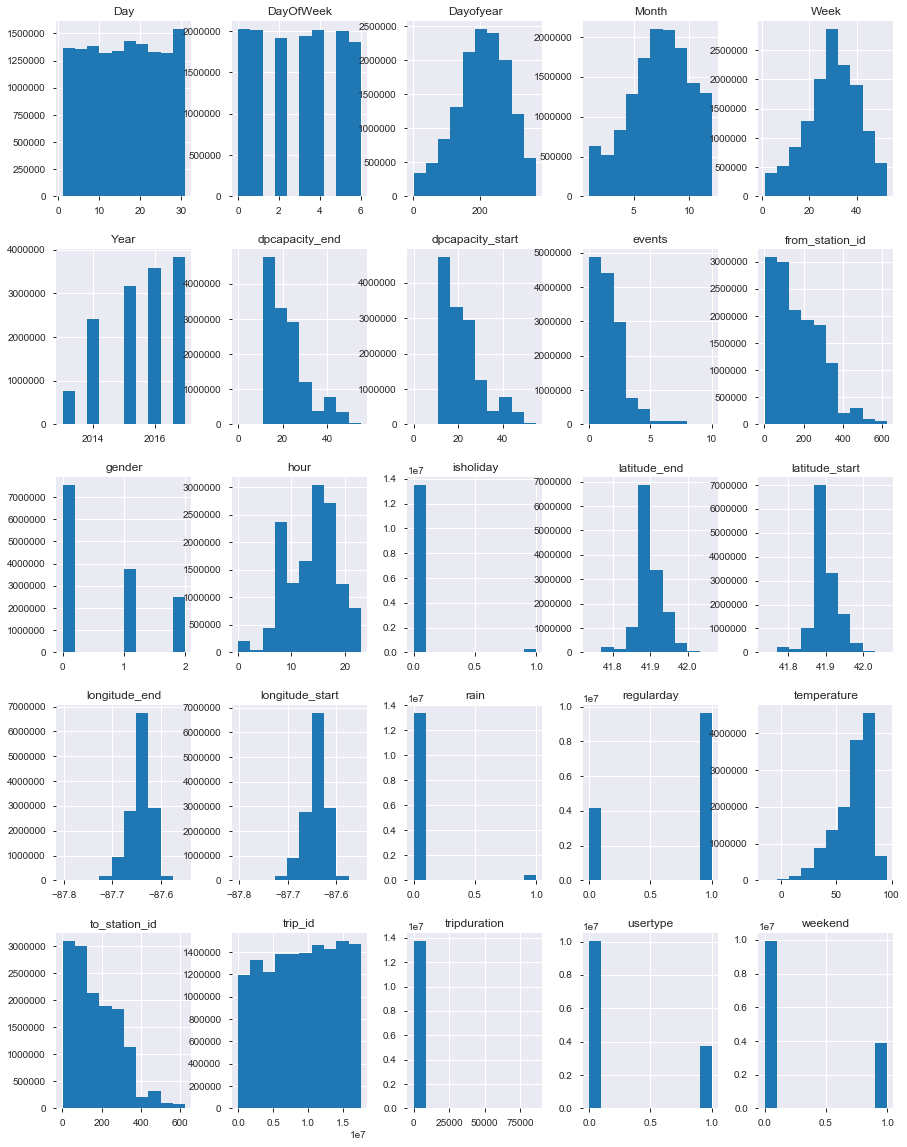

In [38]:
df.hist(figsize = (15,20));

## Removing other weather information we are not focusing on

Since we are focusing on temperature, I am removing the other columns with data regarding pressure, dewpoint etc..

In [39]:
df = df.drop("dpcapacity_end", axis = 1)
df = df.drop("dpcapacity_start", axis = 1)


## Determining max trip duration

(0, 2000)

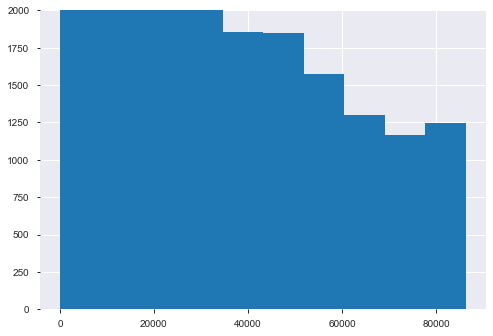

In [40]:
plt.hist(df['tripduration']);
plt.ylim(0, 2000)


I determined that if we are looking at rides in one day, 16 hours would be 6 am - 10 pm or 8 am - midnight and this is a reasonable upper limit for journies and means we don't have values defaulting to 86,399 seconds (1 second less than 24 x 60 x 60)

In [41]:
indexNames = df[(df['tripduration']>57600)].index
df.drop(indexNames, inplace=True)
df.describe()

,trip_id,usertype,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday
count,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07,1.376707e+07
mean,9.088664e+06,2.726337e-01,6.338983e-01,9.872873e+02,1.716006e+02,4.189907e+01,-8.764150e+01,1.717679e+02,4.189952e+01,-8.764161e+01,6.531884e+01,1.184793e+00,3.111512e-02,1.384249e+01,2.969106e+00,2.015531e+03,7.245316e+00,2.971011e+01,1.569414e+01,2.049597e+02,2.800878e-01,2.209410e-02,6.978181e-01
std,5.025581e+06,4.453140e-01,7.702817e-01,1.437377e+03,1.212213e+02,3.404229e-02,2.215942e-02,1.214090e+02,3.418616e-02,2.226015e-02,1.644568e+01,1.285971e+00,1.736288e-01,4.684763e+00,1.996584e+00,1.219173e+00,2.530732e+00,1.100032e+01,8.764558e+00,7.672982e+01,4.490419e-01,1.469896e-01,4.592037e-01
min,3.940000e+03,0.000000e+00,0.000000e+00,6.000000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,2.000000e+00,4.173665e+01,-8.780287e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.856579e+06,0.000000e+00,0.000000e+00,4.150000e+02,7.300000e+01,4.188096e+01,-8.765311e+01,7.300000e+01,4.188096e+01,-8.765350e+01,5.590000e+01,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00,2.015000e+03,6.000000e+00,2.300000e+01,8.000000e+00,1.550000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.257134e+06,0.000000e+00,0.000000e+00,7.150000e+02,1.520000e+02,4.189186e+01,-8.763851e+01,1.500000e+02,4.189228e+01,-8.763851e+01,6.980000e+01,1.000000e+00,0.000000e+00,1.500000e+01,3.000000e+00,2.016000e+03,7.000000e+00,3.000000e+01,1.600000e+01,2.100000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.346111e+07,1.000000e+00,1.000000e+00,1.194000e+03,2.580000e+02,4.191831e+01,-8.762629e+01,2.590000e+02,4.191844e+01,-8.762629e+01,7.810000e+01,2.000000e+00,0.000000e+00,1.700000e+01,5.000000e+00,2.017000e+03,9.000000e+00,3.800000e+01,2.300000e+01,2.620000e+02,1.000000e+00,0.000000e+00,1.000000e+00
max,1.753670e+07,1.000000e+00,2.000000e+00,5.759900e+04,6.260000e+02,4.206431e+01,-8.754939e+01,6.260000e+02,4.206431e+01,-8.754939e+01,9.610000e+01,1.000000e+01,1.000000e+00,2.300000e+01,6.000000e+00,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,3.660000e+02,1.000000e+00,1.000000e+00,1.000000e+00


mean trip duration is now 16.5 minutes and median is 12 minutes

(0, 20000)

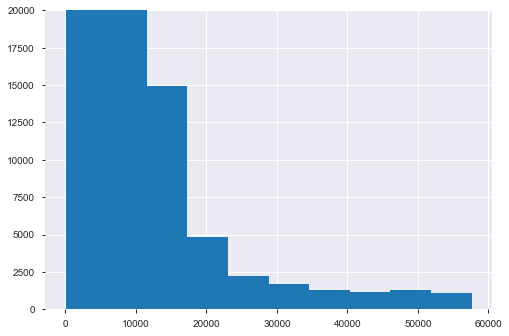

In [42]:
plt.hist(df['tripduration']);
plt.ylim(0, 20000)


## Visualization

I had researched this type of data and found two good resources for visualizaitons:
-     https://github.com/JifuZhao/Chicago-Divvy/blob/master/Chicago%20Divvy%20Data%20Visualization%20and%20Analysis.ipynb
-         https://www.kaggle.com/wesleyliao3/divvy-bikeshare-weather-analysis

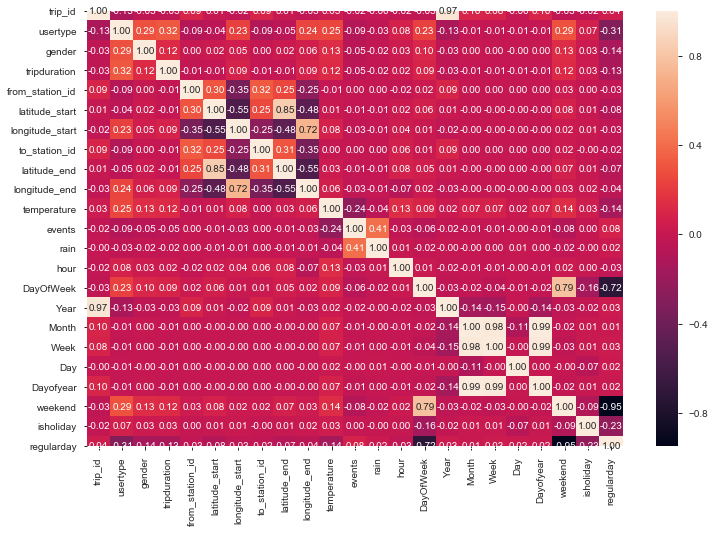

In [43]:
#%matplotlib qt

# correlation coefficient heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='0.2f');



__Trip duration has correlations both with temperature and user type__

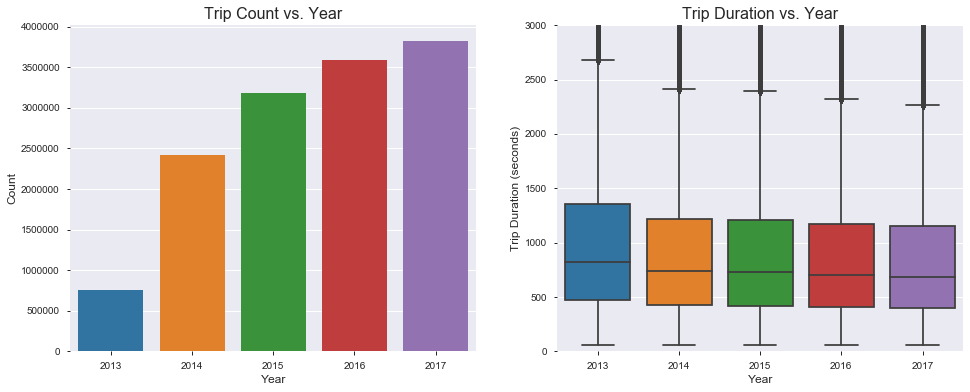

In [44]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='Year', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. Year', fontsize=16)
ax[0].set_xlabel('Year', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='Year', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Year', fontsize=16)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

The number of trips has been increasing year over year (note: even though they follow the trend 2013 was not a complete year and 2017 is also not a complete year)

The 25th, 50th and 75th percentile of trip duration are decreasing year over year

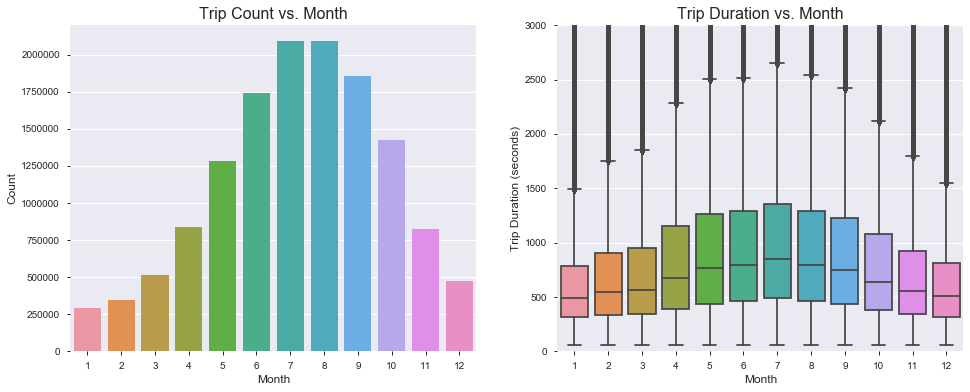

In [45]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='Month', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. Month', fontsize=16)
ax[0].set_xlabel('Month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='Month', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Month', fontsize=16)
ax[1].set_xlabel('Month', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

__There is a huge variation in trip count with month; it increases by a factor of 10 from January to July__

__Additionally the trip duration increases by 50%__

In [46]:
df['temp_round'] = df['temperature']
df['temp_round'] = df['temp_round'].round(-1)

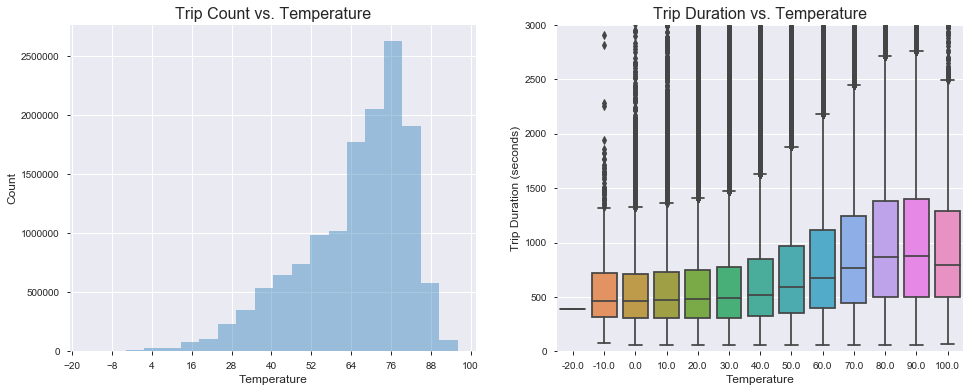

In [47]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(df.temperature, bins=20, ax = ax[0], kde = False)
ax[0].set_title('Trip Count vs. Temperature', fontsize=16)
ax[0].xaxis.set_ticks(np.arange(-20,101,12))
ax[0].set_xlabel('Temperature', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='temp_round', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Temperature', fontsize=16)
ax[1].set_xlabel('Temperature', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

76 degrees is when we see the most number of trips, above 80 we start to see a sharp drop off, and below 50 we see fewer users; however, this may be related to the number of days that are this temperature

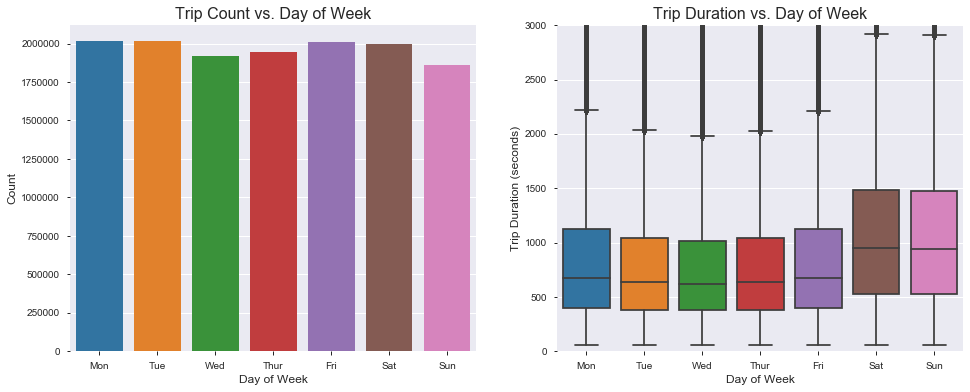

In [48]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='DayOfWeek', data=df, ax=ax[0])
ax[0].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
ax[0].set_title('Trip Count vs. Day of Week', fontsize=16)
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='DayOfWeek', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Day of Week', fontsize=16)
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
ax[1].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
plt.show()

There is not an obvious trend between # of trips and day of the week (although sunday is the lowest)

The trip duration is notably higher for weekends compared to weekdays

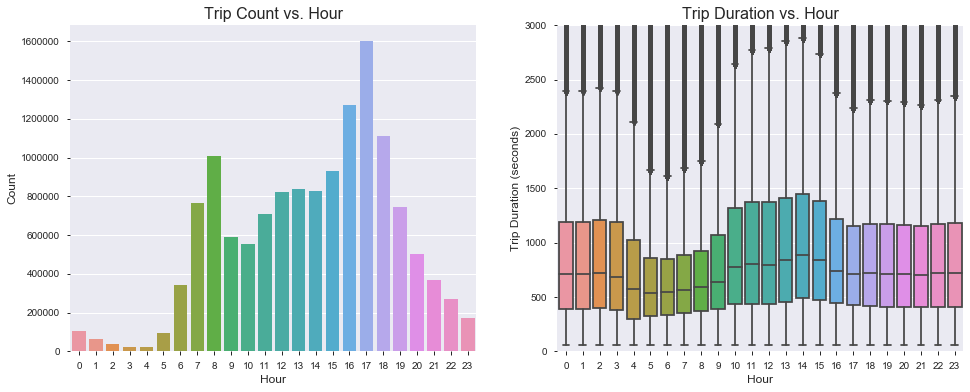

In [49]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='hour', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. Hour', fontsize=16)
ax[0].set_xlabel('Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='hour', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Hour', fontsize=16)
ax[1].set_xlabel('Hour', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

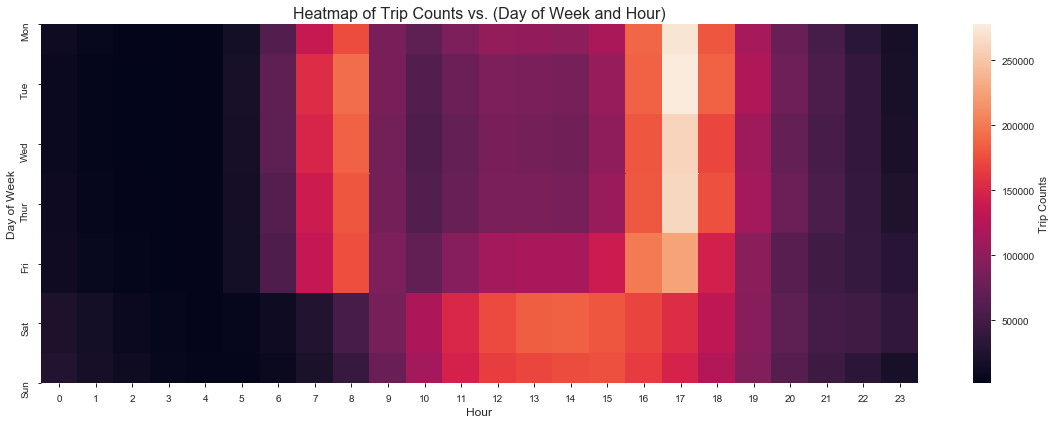

In [50]:
# heatmap of trip count vs. (day and hour)
fig, ax = plt.subplots(figsize=(16, 6))
tmp = df[['DayOfWeek', 'hour', 'tripduration']].groupby(['DayOfWeek', 'hour']).count().reset_index()
pivots = tmp.pivot('DayOfWeek', 'hour', 'tripduration')
sns.heatmap(pivots, cbar_kws={'label': 'Trip Counts'})
ax.set_title('Heatmap of Trip Counts vs. (Day of Week and Hour)', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=10)
plt.tight_layout()
plt.show()

Monday - Friday there are more trips before and after work, whereas on the weekend, there is peak in the middle of the day. The trips in the middle of the day tend to be longer

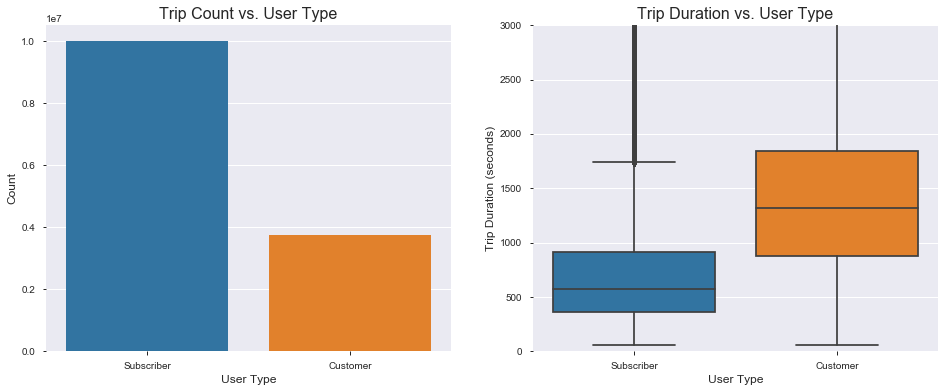

In [51]:
# Trip distribution
# Subscriber: Annual Membership
# Cumtomer: 24-hour pass
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='usertype', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. User Type', fontsize=16)
ax[0].set_xticklabels(('Subscriber', 'Customer'))
ax[0].set_xlabel('User Type', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='usertype', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. User Type', fontsize=16)
ax[1].set_xticklabels(('Subscriber', 'Customer'))
ax[1].set_xlabel('User Type', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

This has the greatest imapct on trip duration
The median value for subscribers is ~8 minutes, whereas it's ~23 minutes for the customers

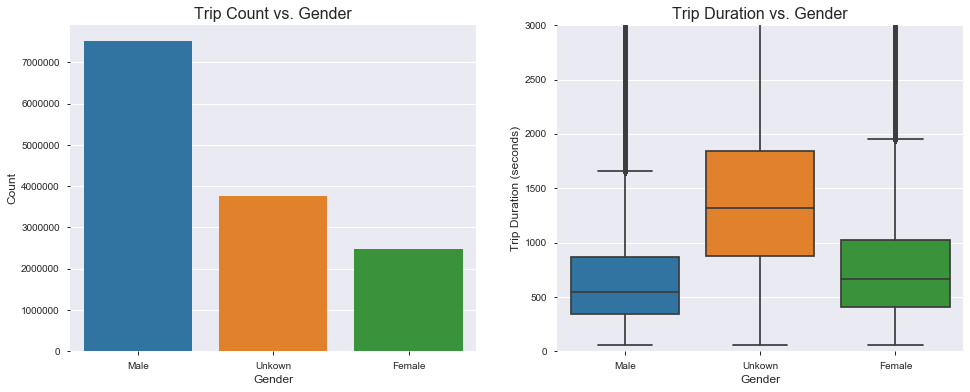

In [52]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='gender', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. Gender', fontsize=16)
ax[0].set_xticklabels(('Male', 'Unkown', 'Female'))
ax[0].set_xlabel('Gender', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='gender', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Gender', fontsize=16)
ax[1].set_xticklabels(('Male', 'Unkown', 'Female'))
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

Women do have longer trips than men, but there is a bigger difference between the type of users than the gender of the users

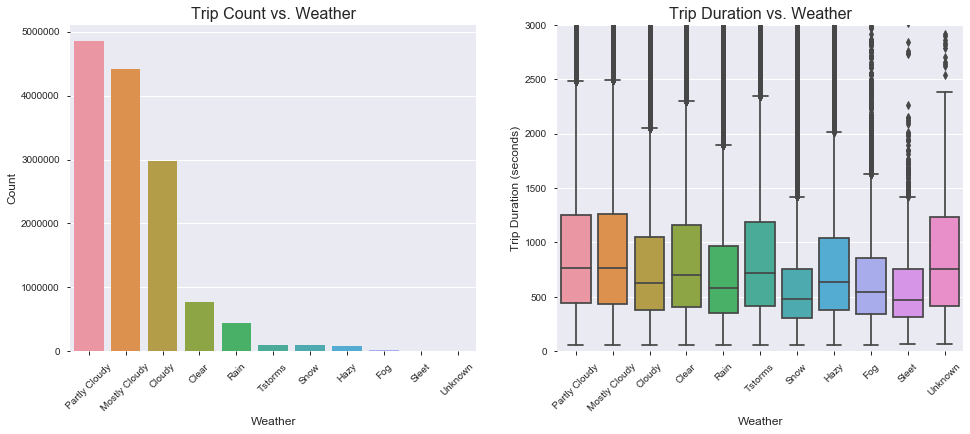

In [53]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='events', data=df, ax=ax[0])
ax[0].set_title('Trip Count vs. Weather', fontsize=16)
ax[0].set_xticklabels(('Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Clear', 'Rain', 'Tstorms', 'Snow', 'Hazy', 'Fog', 'Sleet', 'Unknown'), rotation=45)
ax[0].set_xlabel('Weather', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='events', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Weather', fontsize=16)
ax[1].set_xticklabels(('Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Clear', 'Rain', 'Tstorms', 'Snow', 'Hazy', 'Fog', 'Sleet', 'Unknown'), rotation=45)
ax[1].set_xlabel('Weather', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

Sleet and snow have the shortest trip duration

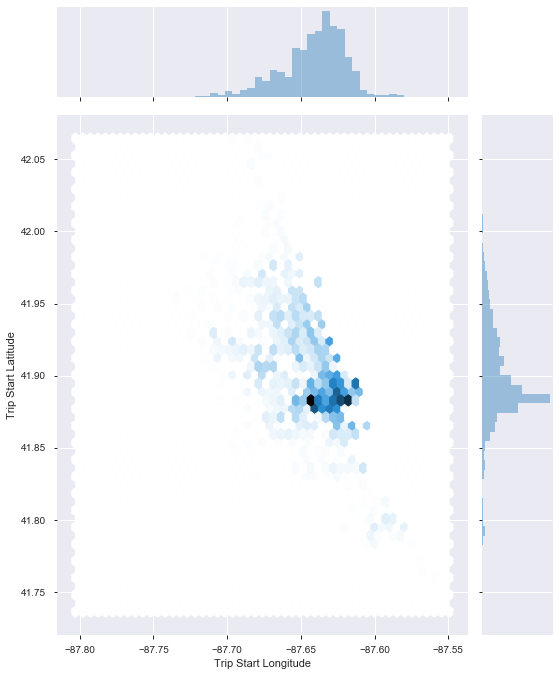

In [54]:
# trip start longitude and latitude distribution
g = sns.jointplot('longitude_start', 'latitude_start', data=df, kind='hex')
g.set_axis_labels('Trip Start Longitude', 'Trip Start Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

More trips start from the center of the city

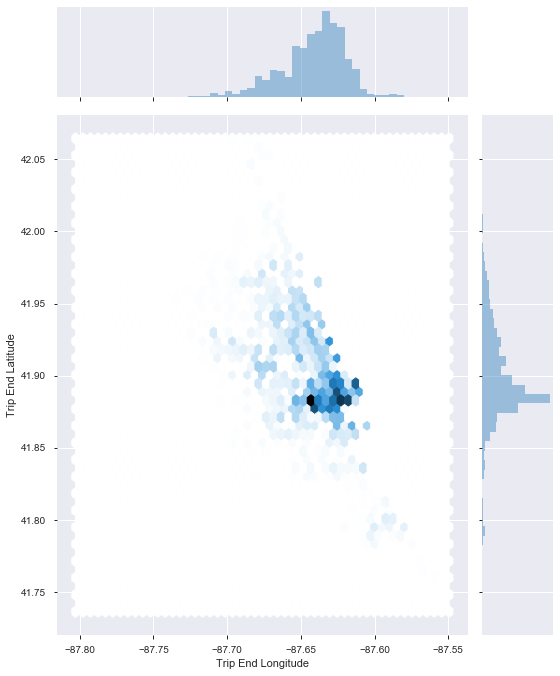

In [55]:
# trip end longitude and latitude distribution
g = sns.jointplot('longitude_end', 'latitude_end', data=df, kind='hex')
g.set_axis_labels('Trip End Longitude', 'Trip End Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

The distribution of trips as a function of location is similar to trip start and trip end

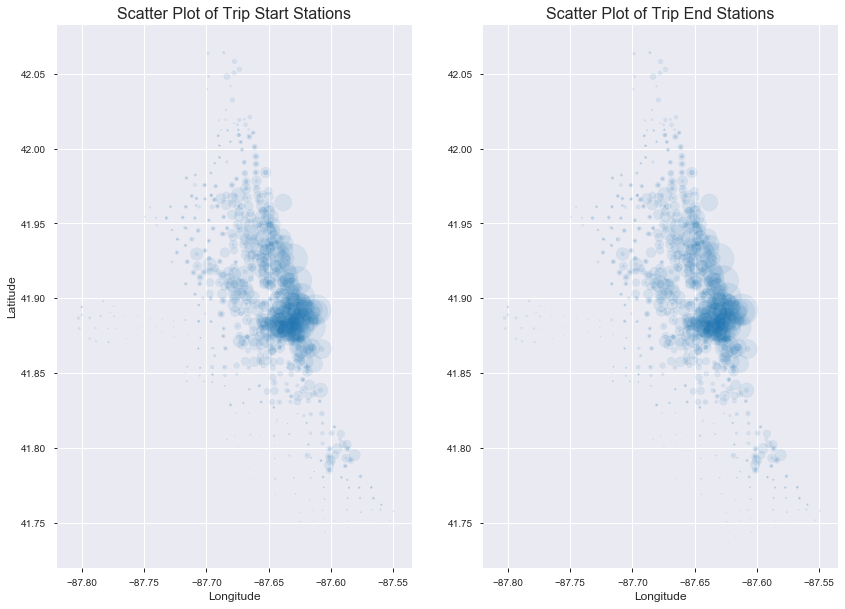

In [56]:
# group station according GPS locations
station_start = df[['longitude_start', 'latitude_start', 'tripduration']]
station_start = station_start.groupby(['longitude_start', 'latitude_start'])
station_start = station_start.count().reset_index()

station_end = df[['longitude_end', 'latitude_end', 'tripduration']]
station_end = station_end.groupby(['longitude_end', 'latitude_end'])
station_end = station_end.count().reset_index()

# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))
x = station_start['longitude_start']
y = station_start['latitude_start']
s = station_start['tripduration'] / 200
ax[0].scatter(x, y, s=s, alpha=0.1)
ax[0].set_title('Scatter Plot of Trip Start Stations', fontsize=16)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

x = station_end['longitude_end']
y = station_end['latitude_end']
s = station_end['tripduration'] / 200
ax[1].scatter(x, y, s=s, alpha=0.1)
ax[1].set_title('Scatter Plot of Trip End Stations', fontsize=16)
ax[1].set_xlabel('Longitude', fontsize=12)

plt.show()

The trip durations as a function of location is similar to trip start and trip end and the longest trips involve the center as one part of the journey

## Visualization by Usertype

Looking at the same figures but segmented by usertype

In [57]:
df_cust = df.loc[df['usertype'] == 1]
df_cust = df_cust.drop("usertype", axis = 1)
df_cust.head()

,trip_id,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday,temp_round
0,4118,1.0,316,85,41.900960,-87.623777,28,41.914680,-87.643320,87.1,1,0,12,3,2013,6,26,27,178,0,0,1,90.0
1,4883,1.0,2272,85,41.900960,-87.623777,85,41.900960,-87.623777,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
2,4875,1.0,977,61,41.907655,-87.672552,16,41.910329,-87.672516,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
3,4874,1.0,972,61,41.907655,-87.672552,16,41.910329,-87.672516,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
4,4869,1.0,964,61,41.907655,-87.672552,17,41.903320,-87.672730,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0


In [58]:
df_cust.describe()

,trip_id,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday,temp_round
count,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06,3.753367e+06
mean,8.027339e+06,9.997488e-01,1.733459e+03,1.544157e+02,4.189664e+01,-8.763313e+01,1.532188e+02,4.189691e+01,-8.763291e+01,7.206309e+01,9.998383e-01,2.278141e-02,1.443476e+01,3.723854e+00,2.015277e+03,7.205064e+00,2.944335e+01,1.555247e+01,2.034771e+02,4.945408e-01,3.831653e-02,4.671427e-01,7.213508e+01
std,5.126340e+06,1.888606e-02,2.145184e+03,1.203671e+02,3.296095e-02,2.145380e-02,1.196683e+02,3.270322e-02,2.146947e-02,1.146749e+01,1.129727e+00,1.492060e-01,4.123252e+00,2.076939e+00,1.276366e+00,1.959596e+00,8.471909e+00,8.841514e+00,5.912791e+01,4.999703e-01,1.919593e-01,4.989193e-01,1.181944e+01
min,4.118000e+03,0.000000e+00,6.000000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,2.000000e+00,4.173665e+01,-8.780287e+01,-1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+01
25%,3.275348e+06,1.000000e+00,8.720000e+02,5.200000e+01,4.188096e+01,-8.764185e+01,5.100000e+01,4.188096e+01,-8.764117e+01,6.690000e+01,0.000000e+00,0.000000e+00,1.200000e+01,2.000000e+00,2.014000e+03,6.000000e+00,2.400000e+01,8.000000e+00,1.640000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+01
50%,7.338702e+06,1.000000e+00,1.317000e+03,1.210000e+02,4.189174e+01,-8.762694e+01,1.180000e+02,4.189186e+01,-8.762680e+01,7.390000e+01,1.000000e+00,0.000000e+00,1.500000e+01,4.000000e+00,2.015000e+03,7.000000e+00,3.000000e+01,1.600000e+01,2.050000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+01
75%,1.218968e+07,1.000000e+00,1.843000e+03,2.490000e+02,4.191468e+01,-8.761787e+01,2.470000e+02,4.191468e+01,-8.761787e+01,8.010000e+01,1.000000e+00,0.000000e+00,1.700000e+01,5.000000e+00,2.016000e+03,9.000000e+00,3.500000e+01,2.300000e+01,2.460000e+02,1.000000e+00,0.000000e+00,1.000000e+00,8.000000e+01
max,1.753670e+07,2.000000e+00,5.759900e+04,6.260000e+02,4.206431e+01,-8.754939e+01,6.260000e+02,4.206431e+01,-8.754939e+01,9.610000e+01,1.000000e+01,1.000000e+00,2.300000e+01,6.000000e+00,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,3.660000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02


In [59]:
df_sub = df.loc[df['usertype'] == 0]
df_sub = df_sub.drop("usertype", axis = 1)
df_sub.head()

,trip_id,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday,temp_round
9,4820,0.0,128,60,41.910578,-87.649422,60,41.910578,-87.649422,75.9,0,0,21,3,2013,6,26,27,178,0,0,1,80.0
11,4814,0.0,128,59,41.867173,-87.625955,59,41.867173,-87.625955,75.9,0,0,21,3,2013,6,26,27,178,0,0,1,80.0
12,4810,0.0,2123,45,41.876066,-87.624433,29,41.900680,-87.662600,75.9,0,0,21,3,2013,6,26,27,178,0,0,1,80.0
13,4797,0.0,748,60,41.910578,-87.649422,60,41.910578,-87.649422,75.9,0,0,21,3,2013,6,26,27,178,0,0,1,80.0
14,4796,0.0,141,60,41.910578,-87.649422,60,41.910578,-87.649422,75.9,0,0,21,3,2013,6,26,27,178,0,0,1,80.0


In [60]:
df_sub_male = df_sub.loc[df_sub['gender'] == 0]
df_sub_male = df_sub_male.drop("gender", axis = 1)
df_sub_female = df_sub.loc[df_sub['gender'] == 2]
df_sub_female = df_sub_female.drop("gender", axis = 1)


In [61]:
df_sub.describe()

,trip_id,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday,temp_round
count,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07,1.001370e+07
mean,9.486473e+06,4.967691e-01,7.076048e+02,1.780419e+02,4.189998e+01,-8.764464e+01,1.787205e+02,4.190049e+01,-8.764487e+01,6.279094e+01,1.254118e+00,3.423879e-02,1.362050e+01,2.686209e+00,2.015626e+03,7.260403e+00,2.981009e+01,1.574724e+01,2.055154e+02,1.997059e-01,1.601356e-02,7.842806e-01,6.281293e+01
std,4.928753e+06,8.640730e-01,9.103180e+02,1.209123e+02,3.439476e-02,2.159768e-02,1.213265e+02,3.467536e-02,2.166634e-02,1.729467e+01,1.333253e+00,1.818420e-01,4.860046e+00,1.889473e+00,1.183049e+00,2.713861e+00,1.180781e+01,8.734947e+00,8.235695e+01,3.997793e-01,1.255274e-01,4.113205e-01,1.751067e+01
min,3.940000e+03,0.000000e+00,6.000000e+01,2.000000e+00,4.173665e+01,-8.780287e+01,2.000000e+00,4.173665e+01,-8.780287e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000e+01
25%,5.324722e+06,0.000000e+00,3.570000e+02,7.600000e+01,4.188103e+01,-8.765475e+01,7.600000e+01,4.188132e+01,-8.765497e+01,5.110000e+01,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,2.015000e+03,5.000000e+00,2.200000e+01,8.000000e+00,1.510000e+02,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+01
50%,9.684233e+06,0.000000e+00,5.740000e+02,1.620000e+02,4.189215e+01,-8.764107e+01,1.620000e+02,4.189383e+01,-8.764107e+01,6.690000e+01,1.000000e+00,0.000000e+00,1.500000e+01,3.000000e+00,2.016000e+03,7.000000e+00,3.100000e+01,1.600000e+01,2.120000e+02,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+01
75%,1.368055e+07,0.000000e+00,9.100000e+02,2.640000e+02,4.191994e+01,-8.763018e+01,2.680000e+02,4.192154e+01,-8.763058e+01,7.590000e+01,2.000000e+00,0.000000e+00,1.700000e+01,4.000000e+00,2.017000e+03,9.000000e+00,3.900000e+01,2.300000e+01,2.690000e+02,0.000000e+00,0.000000e+00,1.000000e+00,8.000000e+01
max,1.753670e+07,2.000000e+00,5.758900e+04,6.260000e+02,4.206431e+01,-8.754939e+01,6.260000e+02,4.206431e+01,-8.754939e+01,9.610000e+01,1.000000e+01,1.000000e+00,2.300000e+01,6.000000e+00,2.017000e+03,1.200000e+01,5.300000e+01,3.100000e+01,3.660000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+02


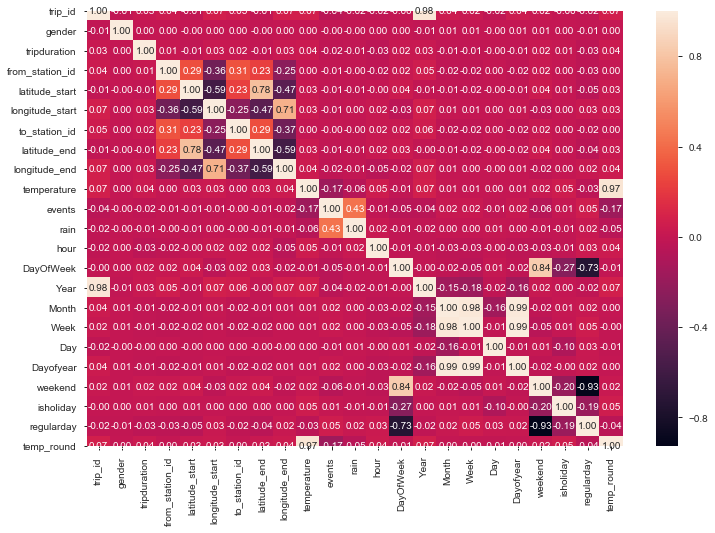

In [62]:
# correlation coefficient heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_cust.corr(method='pearson'), annot=True, fmt='0.2f');



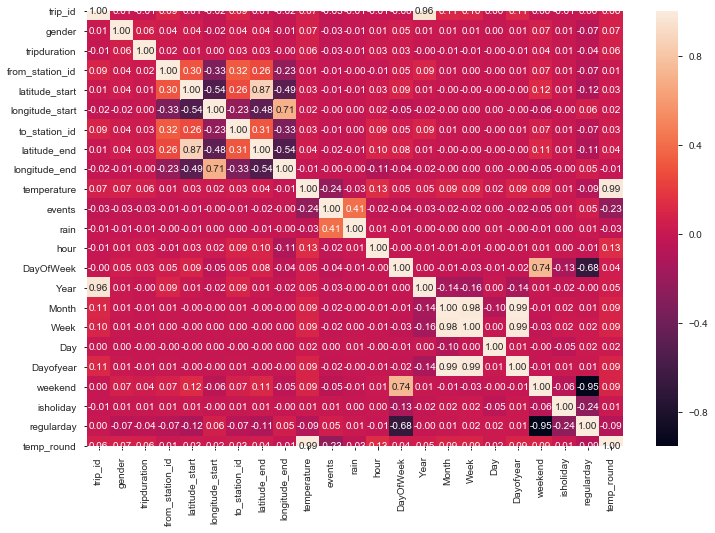

In [63]:
# correlation coefficient heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_sub.corr(method='pearson'), annot=True, fmt='0.2f');



__Trip duration has stronger correlations with temperature for the subscribers than the customers__
Trip duration also has correlations with gender (like we we saw above) as well as a negatie day of the week / regularday

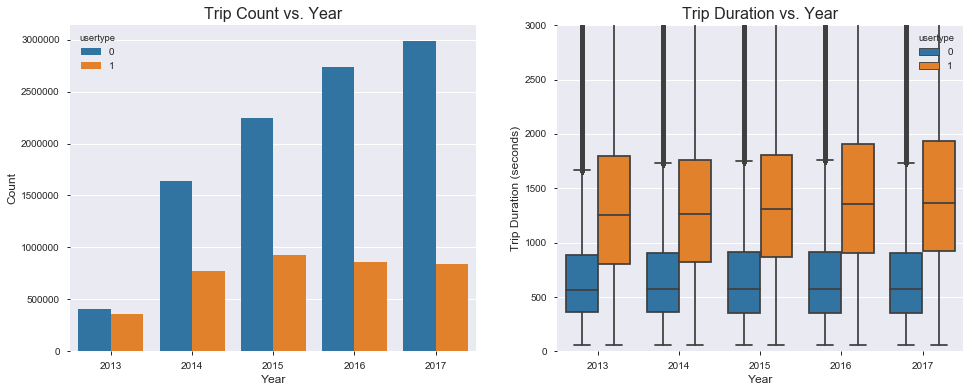

In [64]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='Year', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_title('Trip Count vs. Year', fontsize=16)
ax[0].set_xlabel('Year', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='Year', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Year', fontsize=16)
ax[1].set_xlabel('Year', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

Separating by users, the number of subscribers is increasing year over year, but the number of Customers is static from 2015 => 2016 => 2017

The customers have much longer trips, this has been increasing over time, whereas the subscribers journeys has been quite consistent over the years

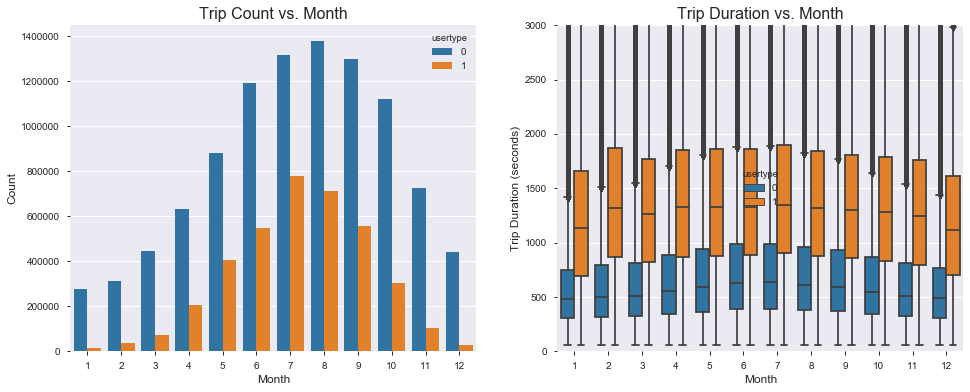

In [65]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='Month', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_title('Trip Count vs. Month', fontsize=16)
ax[0].set_xlabel('Month', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='Month', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Month', fontsize=16)
ax[1].set_xlabel('Month', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

__There is a huge variation in trip count with month; it increases by a factor of 5 from January to July for the subscribers and a factor of 10 for the customers__

There are (proportionally speaking) almost no customers using the bikes in winter

__Trip duration increases a bit between months__

In [66]:
df_cust['temp_round'] = df_cust['temperature']
df_cust['temp_round'] = df_cust['temp_round'].round(-1)

df_sub['temp_round'] = df_sub['temperature']
df_sub['temp_round'] = df_sub['temp_round'].round(-1)

In [67]:
df_sub_male['temp_round'] = df_sub_male['temperature']
df_sub_male['temp_round'] = df_sub_male['temp_round'].round(-1)

df_sub_female['temp_round'] = df_sub_female['temperature']
df_sub_female['temp_round'] = df_sub_female['temp_round'].round(-1)


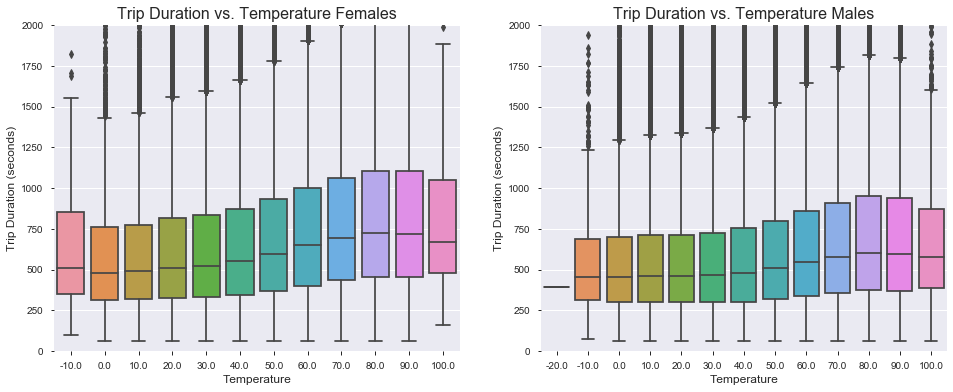

In [68]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(x='temp_round', y='tripduration', data=df_sub_female, ax=ax[0])
ax[0].set_title('Trip Duration vs. Temperature Females', fontsize=16)
ax[0].set_xlabel('Temperature', fontsize=12)
ax[0].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[0].set_ylim(0,2000)
sns.boxplot(x='temp_round', y='tripduration', data=df_sub_male, ax=ax[1])
ax[1].set_title('Trip Duration vs. Temperature Males', fontsize=16)
ax[1].set_xlabel('Temperature', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,2000)
plt.show()

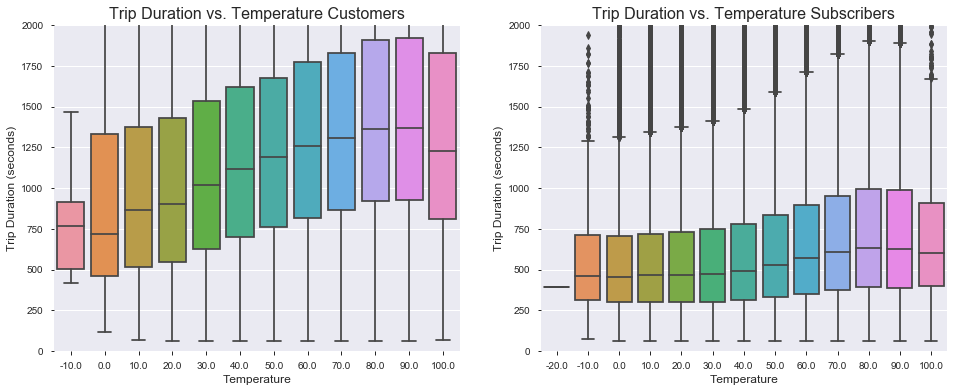

In [69]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.boxplot(x='temp_round', y='tripduration', data=df_cust, ax=ax[0])
ax[0].set_title('Trip Duration vs. Temperature Customers', fontsize=16)
ax[0].set_xlabel('Temperature', fontsize=12)
ax[0].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[0].set_ylim(0,2000)
sns.boxplot(x='temp_round', y='tripduration', data=df_sub, ax=ax[1])
ax[1].set_title('Trip Duration vs. Temperature Subscribers', fontsize=16)
ax[1].set_xlabel('Temperature', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,2000)
plt.show()

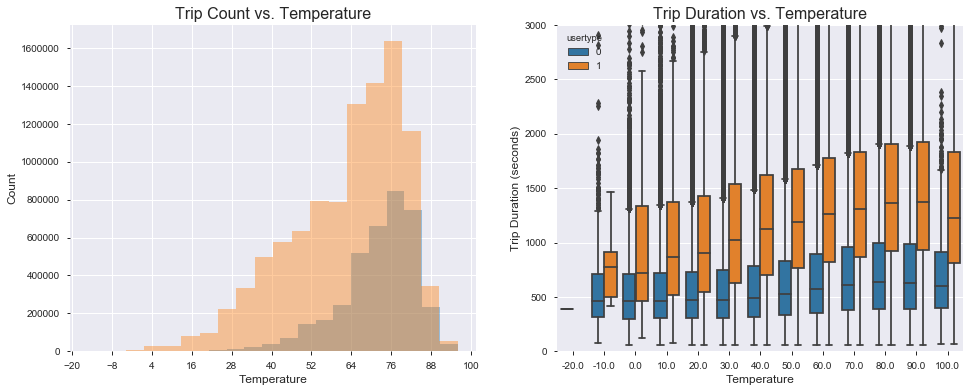

In [70]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(df[df['usertype']==1].temperature, label = 'Customer', bins=20, ax = ax[0], kde =False)
sns.distplot(df[df['usertype']==0].temperature, label = 'Subscriber', bins=20, ax = ax[0], kde =False)
ax[0].set_title('Trip Count vs. Temperature', fontsize=16)
ax[0].xaxis.set_ticks(np.arange(-20,101,12))
ax[0].set_xlabel('Temperature', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='temp_round', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Temperature', fontsize=16)
ax[1].set_xlabel('Temperature', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

There are proportionately fewer customers using the service in colder temperature

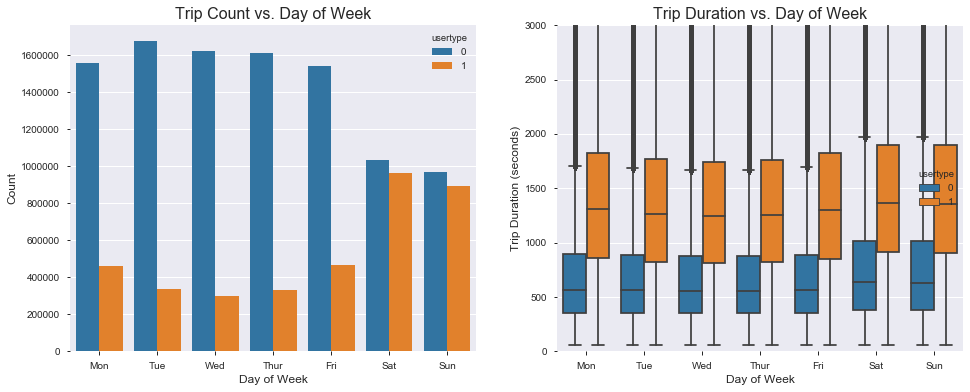

In [71]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='DayOfWeek', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
ax[0].set_title('Trip Count vs. Day of Week', fontsize=16)
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='DayOfWeek', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Day of Week', fontsize=16)
ax[1].set_xlabel('Day of Week', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
ax[1].set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
plt.show()

__the customers use the bikes on the weekend and the subscribers use it during the week, implying at least half of them are commuting__


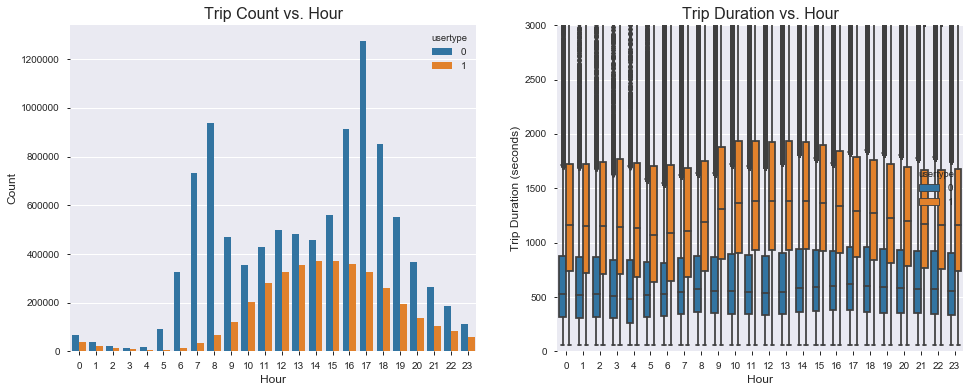

In [72]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='hour', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_title('Trip Count vs. Hour', fontsize=16)
ax[0].set_xlabel('Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='hour', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Hour', fontsize=16)
ax[1].set_xlabel('Hour', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

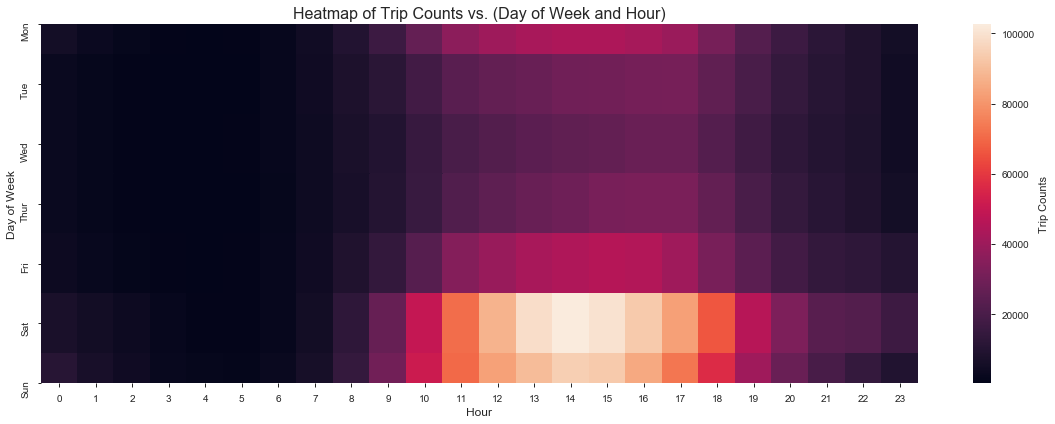

In [73]:
# heatmap of trip count vs. (day and hour)
fig, ax = plt.subplots(figsize=(16, 6))
tmp = df_cust[['DayOfWeek', 'hour', 'tripduration']].groupby(['DayOfWeek', 'hour']).count().reset_index()
pivots = tmp.pivot('DayOfWeek', 'hour', 'tripduration')
sns.heatmap(pivots, cbar_kws={'label': 'Trip Counts'})
ax.set_title('Heatmap of Trip Counts vs. (Day of Week and Hour)', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=10)
plt.tight_layout()
plt.show()

The customers are not using the bikes during commute hours

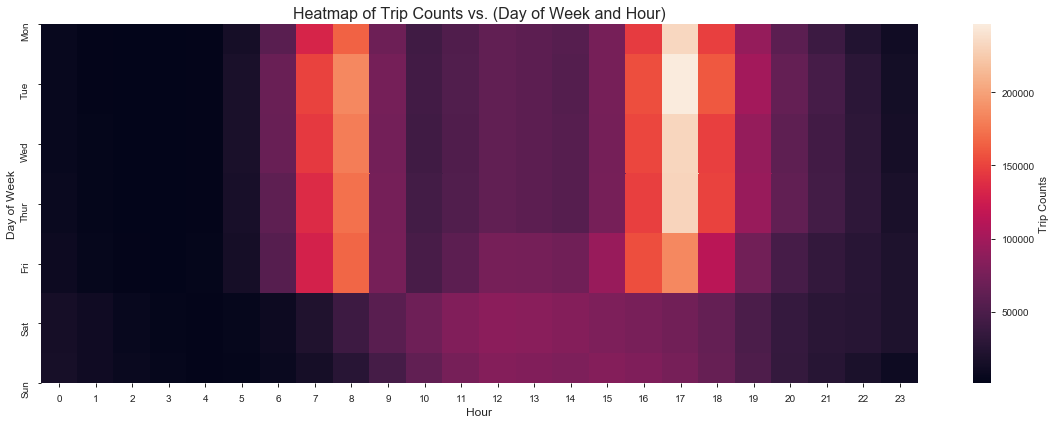

In [74]:
# heatmap of trip count vs. (day and hour)
fig, ax = plt.subplots(figsize=(16, 6))
tmp = df_sub[['DayOfWeek', 'hour', 'tripduration']].groupby(['DayOfWeek', 'hour']).count().reset_index()
pivots = tmp.pivot('DayOfWeek', 'hour', 'tripduration')
sns.heatmap(pivots, cbar_kws={'label': 'Trip Counts'})
ax.set_title('Heatmap of Trip Counts vs. (Day of Week and Hour)', fontsize=16)
ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_yticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize=10)
plt.tight_layout()
plt.show()

The predominant use of the bikes for the subscribers is during commute hours on monday to friday

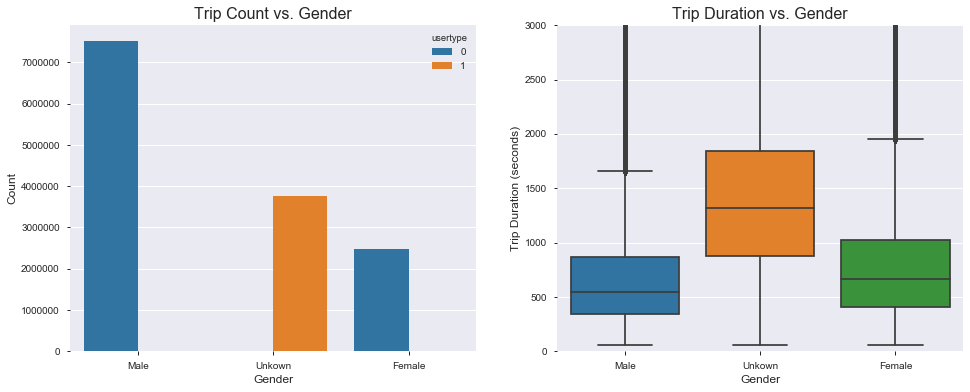

In [75]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='gender', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_title('Trip Count vs. Gender', fontsize=16)
ax[0].set_xticklabels(('Male', 'Unkown', 'Female'))
ax[0].set_xlabel('Gender', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='gender', y='tripduration', data=df, ax=ax[1])
ax[1].set_title('Trip Duration vs. Gender', fontsize=16)
ax[1].set_xticklabels(('Male', 'Unkown', 'Female'))
ax[1].set_xlabel('Gender', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

We do not know the gender of the subscribers

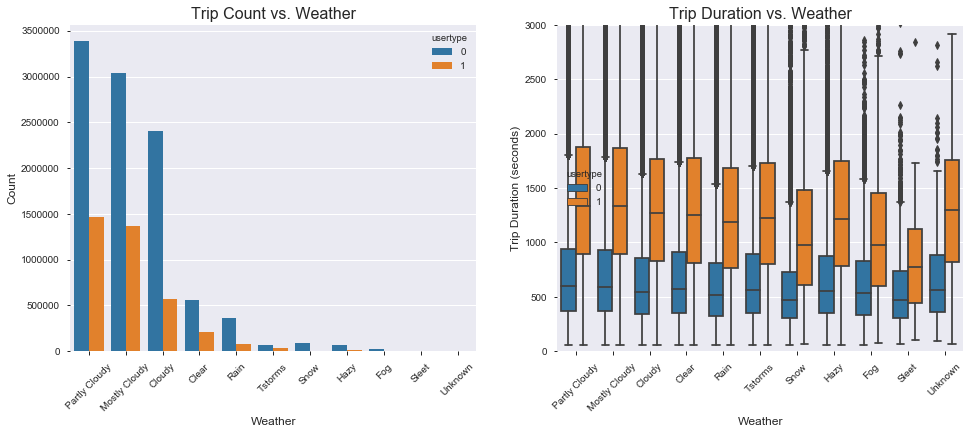

In [76]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='events', data=df, ax=ax[0], hue = 'usertype')
ax[0].set_title('Trip Count vs. Weather', fontsize=16)
ax[0].set_xticklabels(('Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Clear', 'Rain', 'Tstorms', 'Snow', 'Hazy', 'Fog', 'Sleet', 'Unknown'), rotation=45)
ax[0].set_xlabel('Weather', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='events', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Weather', fontsize=16)
ax[1].set_xticklabels(('Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Clear', 'Rain', 'Tstorms', 'Snow', 'Hazy', 'Fog', 'Sleet', 'Unknown'), rotation=45)
ax[1].set_xlabel('Weather', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

Sleet and snow affect the customers more than the subscribers

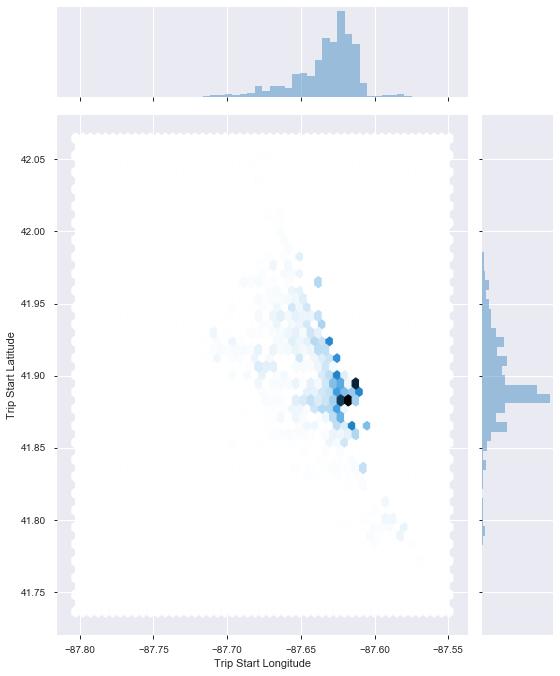

In [77]:
# trip start longitude and latitude distribution
g = sns.jointplot('longitude_start', 'latitude_start', data=df_cust, kind='hex')
g.set_axis_labels('Trip Start Longitude', 'Trip Start Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

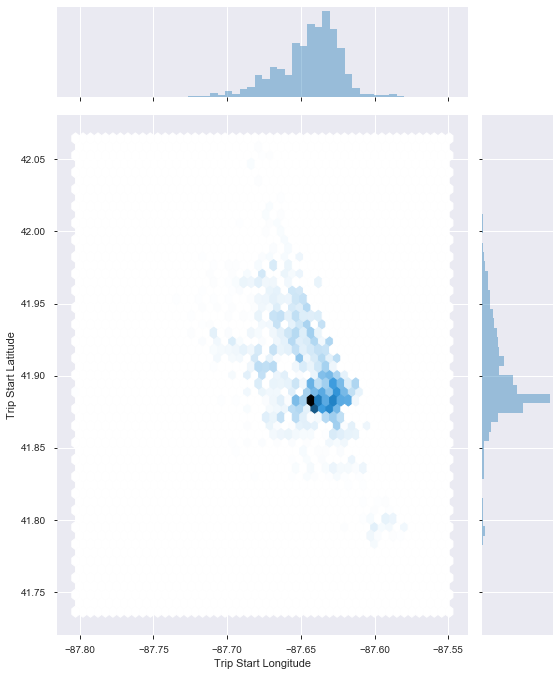

In [78]:
# trip start longitude and latitude distribution
g = sns.jointplot('longitude_start', 'latitude_start', data=df_sub, kind='hex')
g.set_axis_labels('Trip Start Longitude', 'Trip Start Latitude')
g.fig.set_figwidth(8)
g.fig.set_figheight(10)
plt.show()

There is a difference in the location of the usertypes, the customers are more focused around the center

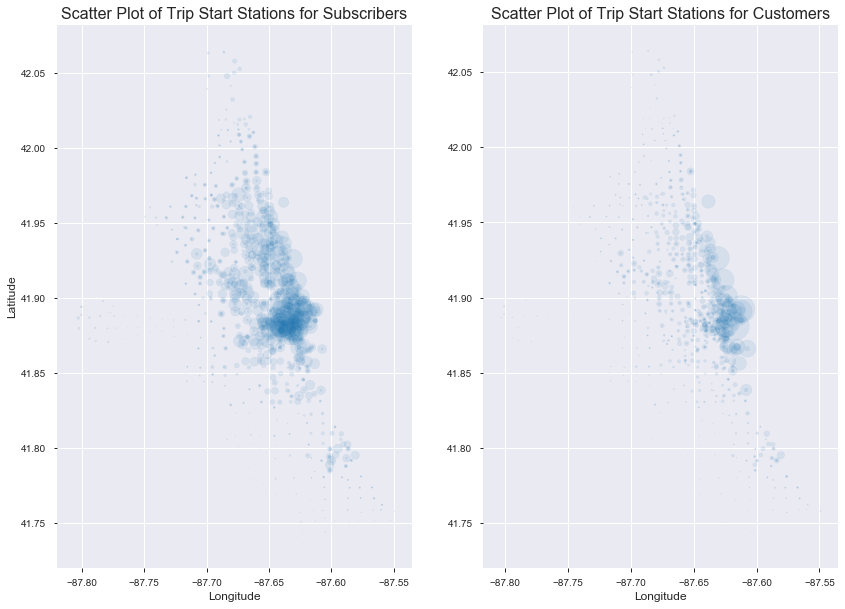

In [79]:
# group station according GPS locations
station_sub = df_sub[['longitude_start', 'latitude_start', 'tripduration']]
station_sub = station_sub.groupby(['longitude_start', 'latitude_start'])
station_sub = station_sub.count().reset_index()

station_cust = df_cust[['longitude_start', 'latitude_start', 'tripduration']]
station_cust = station_cust.groupby(['longitude_start', 'latitude_start'])
station_cust = station_cust.count().reset_index()

# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))
x = station_sub['longitude_start']
y = station_sub['latitude_start']
s = station_sub['tripduration'] / 200
ax[0].scatter(x, y, s=s, alpha=0.1)
ax[0].set_title('Scatter Plot of Trip Start Stations for Subscribers', fontsize=16)
ax[0].set_xlabel('Longitude', fontsize=12)
ax[0].set_ylabel('Latitude', fontsize=12)

x = station_cust['longitude_start']
y = station_cust['latitude_start']
s = station_cust['tripduration'] / 200
ax[1].scatter(x, y, s=s, alpha=0.1)
ax[1].set_title('Scatter Plot of Trip Start Stations for Customers', fontsize=16)
ax[1].set_xlabel('Longitude', fontsize=12)

plt.show()

The customers are using the bikes the most in the center and along the coast, whereas the subscribers use the bikes further out and use the bikes more

# Dependence of Temperature on Count and Duration by Users

Although there is interesting data on:
- location
- gender (for subscribers)
- weather events

I am going to focus the remainder of the project on:
- UserType
- Temperature
- Time (hour, day, month, year)

In [80]:
df.head()

,trip_id,usertype,gender,tripduration,from_station_id,latitude_start,longitude_start,to_station_id,latitude_end,longitude_end,temperature,events,rain,hour,DayOfWeek,Year,Month,Week,Day,Dayofyear,weekend,isholiday,regularday,temp_round
0,4118,1,1.0,316,85,41.900960,-87.623777,28,41.914680,-87.643320,87.1,1,0,12,3,2013,6,26,27,178,0,0,1,90.0
1,4883,1,1.0,2272,85,41.900960,-87.623777,85,41.900960,-87.623777,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
2,4875,1,1.0,977,61,41.907655,-87.672552,16,41.910329,-87.672516,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
3,4874,1,1.0,972,61,41.907655,-87.672552,16,41.910329,-87.672516,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0
4,4869,1,1.0,964,61,41.907655,-87.672552,17,41.903320,-87.672730,75.0,0,0,22,3,2013,6,26,27,178,0,0,1,80.0


Is the temperature data hourly or daily?

In [81]:
daily = df[['Year', 'Month', 'Week', 'Day', 'events', 'temperature']].drop_duplicates().shape[0] \
            == df[['Year', 'Month', 'Week', 'Day']].drop_duplicates().shape[0]

# Is it hourly?
hourly = df[['Year', 'Month', 'Week', 'Day', 'hour', 'events', 'temperature']].drop_duplicates().shape[0] \
            == df[['Year', 'Month', 'Week', 'Day', 'hour']].drop_duplicates().shape[0]
print("Daily?", daily, "; Hourly?", hourly)

Daily? False ; Hourly? True


## Hourly Data

In [82]:
df['tripcount'] = 1
df_hourly = df.groupby(['Year', 'Month', 'Week', 'DayOfWeek', 'Day', 'hour', 'regularday', 'temperature']) \
                 .agg({'tripcount':'sum', 'tripduration':'sum'}).reset_index()
df_hourly['avg_duration'] = df_hourly['tripduration'] / df_hourly['tripcount']
df_hourly.head()

,Year,Month,Week,DayOfWeek,Day,hour,regularday,temperature,tripcount,tripduration,avg_duration
0,2013,6,26,3,27,1,1,66.0,1,31177,31177.000000
1,2013,6,26,3,27,11,1,84.9,4,27659,6914.750000
2,2013,6,26,3,27,12,1,87.1,3,677,225.666667
3,2013,6,26,3,27,13,1,88.0,2,22720,11360.000000
4,2013,6,26,3,27,14,1,89.1,5,1112,222.400000


In [83]:
df_cust['tripcount'] = 1
df_hourly_cust = df_cust.groupby(['Year', 'Month', 'Week', 'DayOfWeek', 'Day', 'hour', 'regularday', 'temperature']) \
                 .agg({'tripcount':'sum', 'tripduration':'sum'}).reset_index()
df_hourly_cust['avg_duration'] = df_hourly_cust['tripduration'] / df_hourly_cust['tripcount']

df_sub['tripcount'] = 1
df_hourly_sub = df_sub.groupby(['Year', 'Month', 'Week', 'DayOfWeek', 'Day', 'hour', 'regularday', 'temperature']) \
                 .agg({'tripcount':'sum', 'tripduration':'sum'}).reset_index()
df_hourly_sub['avg_duration'] = df_hourly_sub['tripduration'] / df_hourly_sub['tripcount']


In [84]:
df_sub_male['tripcount'] = 1
df_hourly_sub_male = df_sub_male.groupby(['Year', 'Month', 'Week', 'DayOfWeek', 'Day', 'hour', 'regularday', 'temperature']) \
                 .agg({'tripcount':'sum', 'tripduration':'sum'}).reset_index()
df_hourly_sub_male['avg_duration'] = df_hourly_sub_male['tripduration'] / df_hourly_sub_male['tripcount']

df_sub_female['tripcount'] = 1
df_hourly_sub_female = df_sub_female.groupby(['Year', 'Month', 'Week', 'DayOfWeek', 'Day', 'hour', 'regularday', 'temperature']) \
                 .agg({'tripcount':'sum', 'tripduration':'sum'}).reset_index()
df_hourly_sub_female['avg_duration'] = df_hourly_sub_female['tripduration'] / df_hourly_sub_female['tripcount']


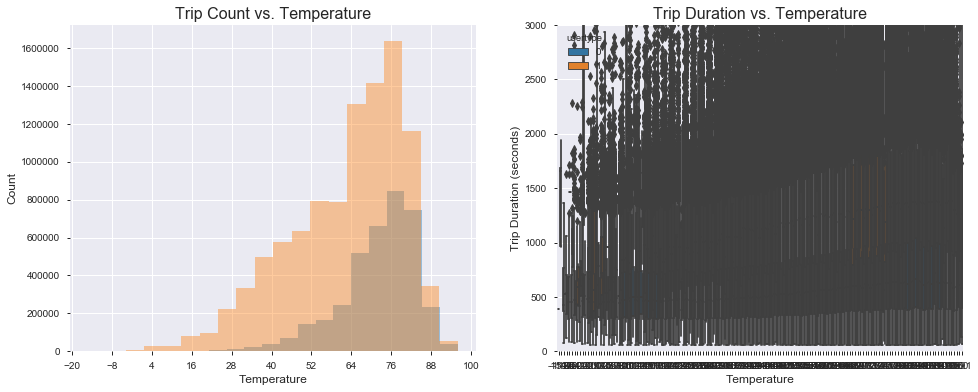

In [85]:
# Trip distribution
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.distplot(df[df['usertype']==1].temperature, label = 'Customer', bins=20, ax = ax[0], kde =False)
sns.distplot(df[df['usertype']==0].temperature, label = 'Subscriber', bins=20, ax = ax[0], kde =False)
ax[0].set_title('Trip Count vs. Temperature', fontsize=16)
ax[0].xaxis.set_ticks(np.arange(-20,101,12))
ax[0].set_xlabel('Temperature', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
sns.boxplot(x='temperature', y='tripduration', data=df, ax=ax[1], hue = 'usertype')
ax[1].set_title('Trip Duration vs. Temperature', fontsize=16)
ax[1].set_xlabel('Temperature', fontsize=12)
ax[1].set_ylabel('Trip Duration (seconds)', fontsize=12)
ax[1].set_ylim(0,3000)
plt.show()

## Effect of temperature vs # of days at that temperature

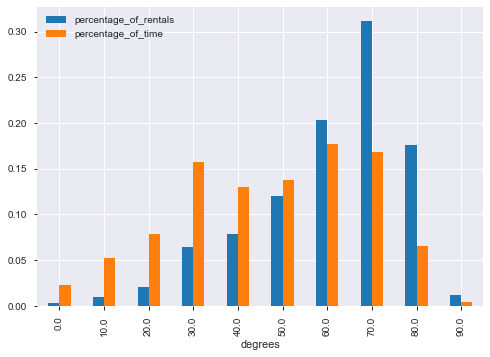

In [86]:
# Everyone
percent = pd.DataFrame(np.vstack((range(0,100,10), np.histogram(df['temperature'], range = (0,100))[0]/df.shape[0],
                              np.histogram(df_hourly['temperature'], range = (0, 100))[0]/df_hourly.shape[0])).T)
percent.columns = ['degrees', 'percentage_of_rentals', 'percentage_of_time']
percent = percent.set_index('degrees')
percent.plot(kind = 'bar');


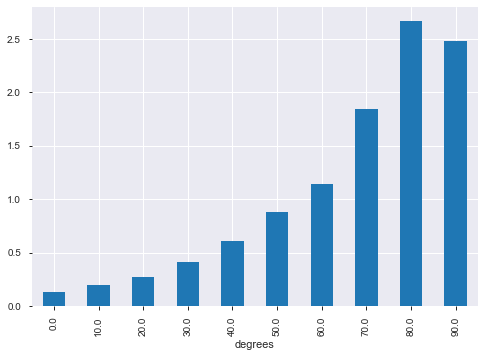

In [87]:
percent['normalized'] = percent['percentage_of_rentals']/percent['percentage_of_time']
percent['normalized'].plot(kind = 'bar');

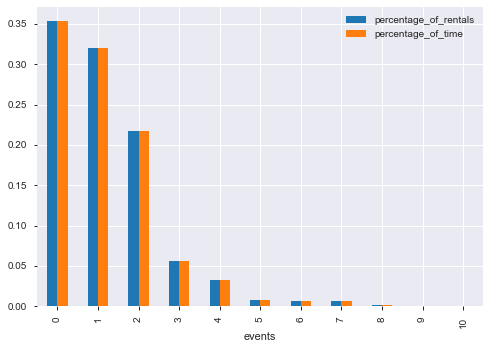

In [88]:
df_total = pd.DataFrame(df['events'].value_counts() / df.shape[0]).reset_index()
df_rides = pd.DataFrame(df['events'].value_counts() / df.shape[0]).reset_index()
df_total.columns = ['events', 'percentage_of_time']
df_rides.columns = ['events', 'percentage_of_rentals']
pd.merge(df_rides, df_total, on = 'events').set_index('events').plot(kind = 'bar');

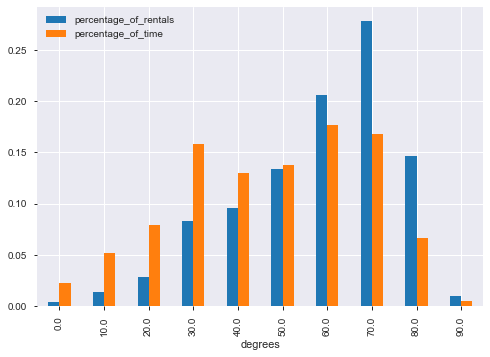

In [89]:
#Subscribers
percent_sub = pd.DataFrame(np.vstack((range(0,100,10), np.histogram(df_sub['temperature'], range = (0,100))[0]/df_sub.shape[0],
                              np.histogram(df_hourly_sub['temperature'], range = (0, 100))[0]/df_hourly_sub.shape[0])).T)
percent_sub.columns = ['degrees', 'percentage_of_rentals', 'percentage_of_time']
percent_sub = percent_sub.set_index('degrees')
percent_sub.plot(kind = 'bar');


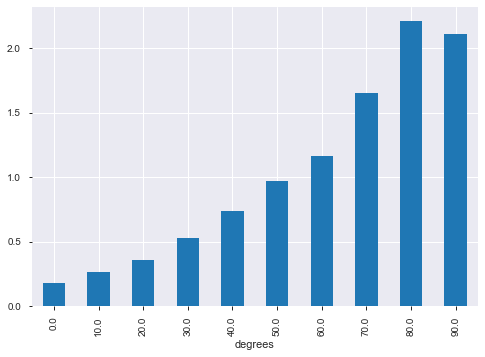

In [90]:
#Subscribers
percent_sub['normalized'] = percent_sub['percentage_of_rentals']/percent_sub['percentage_of_time']
percent_sub['normalized'].plot(kind = 'bar');


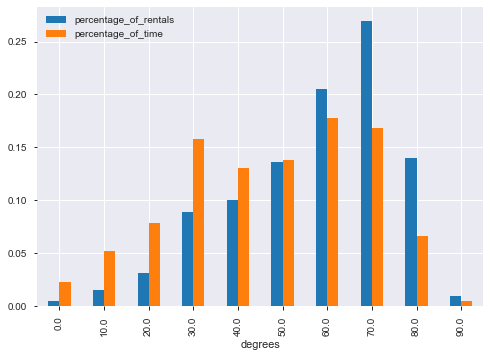

In [91]:
#Subscribers Male
percent_sub_male = pd.DataFrame(np.vstack((range(0,100,10), np.histogram(df_sub_male['temperature'], range = (0,100))[0]/df_sub_male.shape[0],
                              np.histogram(df_hourly_sub_male['temperature'], range = (0, 100))[0]/df_hourly_sub_male.shape[0])).T)
percent_sub_male.columns = ['degrees', 'percentage_of_rentals', 'percentage_of_time']
percent_sub_male = percent_sub_male.set_index('degrees')
percent_sub_male.plot(kind = 'bar');


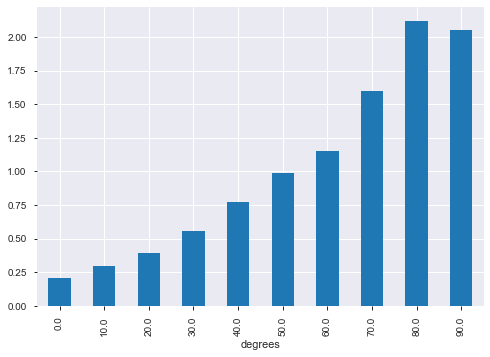

In [92]:
#Subscribers Male
percent_sub_male['normalized'] = percent_sub_male['percentage_of_rentals']/percent_sub_male['percentage_of_time']
percent_sub_male['normalized'].plot(kind = 'bar');


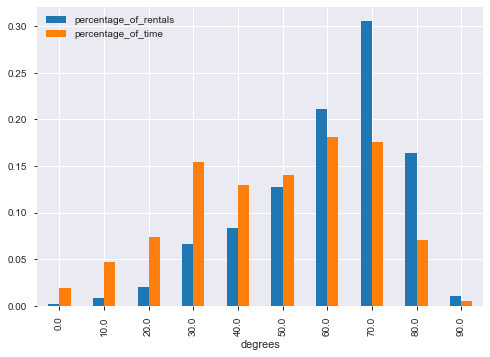

In [93]:
#Subscribers Female
percent_sub_female = pd.DataFrame(np.vstack((range(0,100,10), np.histogram(df_sub_female['temperature'], range = (0,100))[0]/df_sub_female.shape[0],
                              np.histogram(df_hourly_sub_female['temperature'], range = (0, 100))[0]/df_hourly_sub_female.shape[0])).T)
percent_sub_female.columns = ['degrees', 'percentage_of_rentals', 'percentage_of_time']
percent_sub_female = percent_sub_female.set_index('degrees')
percent_sub_female.plot(kind = 'bar');


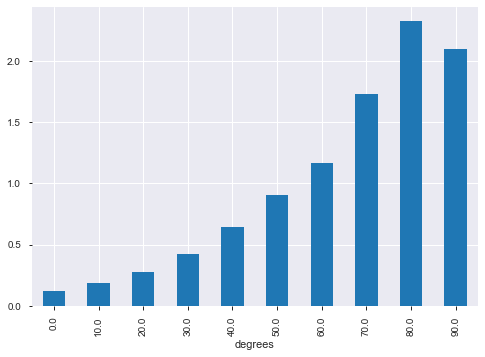

In [94]:
#Subscribers Female
percent_sub_female['normalized'] = percent_sub_female['percentage_of_rentals']/percent_sub_female['percentage_of_time']
percent_sub_female['normalized'].plot(kind = 'bar');


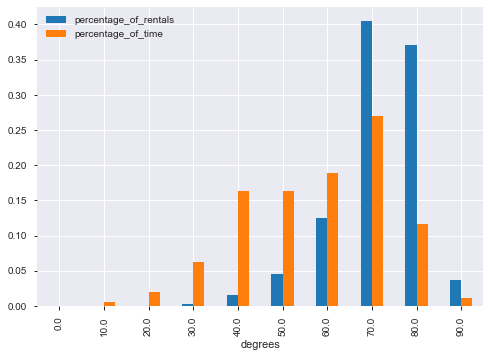

In [95]:
#Daily users
percent_cust = pd.DataFrame(np.vstack((range(0,100,10), np.histogram(df_cust['temperature'], range = (-20,100))[0]/df_cust.shape[0],
                              np.histogram(df_hourly_cust['temperature'], range = (-20, 100))[0]/df_hourly_cust.shape[0])).T)
percent_cust.columns = ['degrees', 'percentage_of_rentals', 'percentage_of_time']
percent_cust = percent_cust.set_index('degrees')

percent_cust.plot(kind = 'bar');



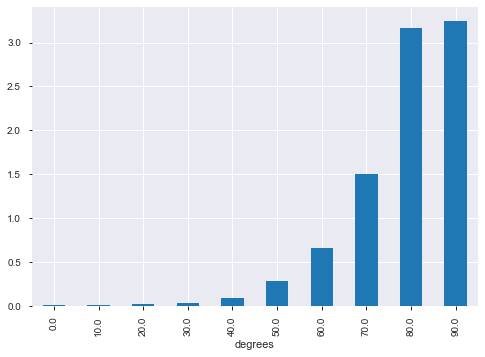

In [96]:
#Daily users
percent_cust['normalized'] = percent_cust['percentage_of_rentals']/percent_cust['percentage_of_time']
percent_cust['normalized'].plot(kind = 'bar');


In [97]:
percent_both = percent_cust.join(percent_sub_male, lsuffix='_cust', rsuffix='_sub')
percent_both = percent_both.drop("percentage_of_rentals_cust", axis = 1)
percent_both = percent_both.drop("percentage_of_time_cust", axis = 1)
percent_both = percent_both.drop("percentage_of_rentals_sub", axis = 1)
percent_both = percent_both.drop("percentage_of_time_sub", axis = 1)
percent_both = percent_both.rename(columns={"normalized_cust": "Customers", "normalized_sub": "Subscribers - Male"})
percent_both

,Customers,Subscribers - Male
degrees,,
0.0,0.009152,0.206144
10.0,0.014575,0.294982
20.0,0.022341,0.391006
30.0,0.038524,0.560523
40.0,0.091890,0.770802
50.0,0.279111,0.988640
60.0,0.662204,1.155370
70.0,1.502500,1.599071
80.0,3.167452,2.116952


In [98]:
percent_sub_female

,percentage_of_rentals,percentage_of_time,normalized
degrees,,,
0.0,0.002274,0.019104,0.119026
10.0,0.008851,0.046835,0.188976
20.0,0.020483,0.073437,0.278923
30.0,0.065996,0.154703,0.426598
40.0,0.083756,0.129783,0.645356
50.0,0.127194,0.140423,0.905789
60.0,0.211213,0.180615,1.169409
70.0,0.305295,0.176150,1.733156
80.0,0.164163,0.070653,2.323513


In [99]:
percent_all = percent_both.join(percent_sub_female)
percent_all = percent_all.drop("percentage_of_rentals", axis = 1)
percent_all = percent_all.drop("percentage_of_time", axis = 1)
percent_all = percent_all.reset_index()
percent_all = percent_all.rename(columns={"normalized": "Subscribers - Female"})
percent_all

,degrees,Customers,Subscribers - Male,Subscribers - Female
0,0.0,0.009152,0.206144,0.119026
1,10.0,0.014575,0.294982,0.188976
2,20.0,0.022341,0.391006,0.278923
3,30.0,0.038524,0.560523,0.426598
4,40.0,0.091890,0.770802,0.645356
5,50.0,0.279111,0.988640,0.905789
6,60.0,0.662204,1.155370,1.169409
7,70.0,1.502500,1.599071,1.733156
8,80.0,3.167452,2.116952,2.323513
9,90.0,3.243131,2.055026,2.099184


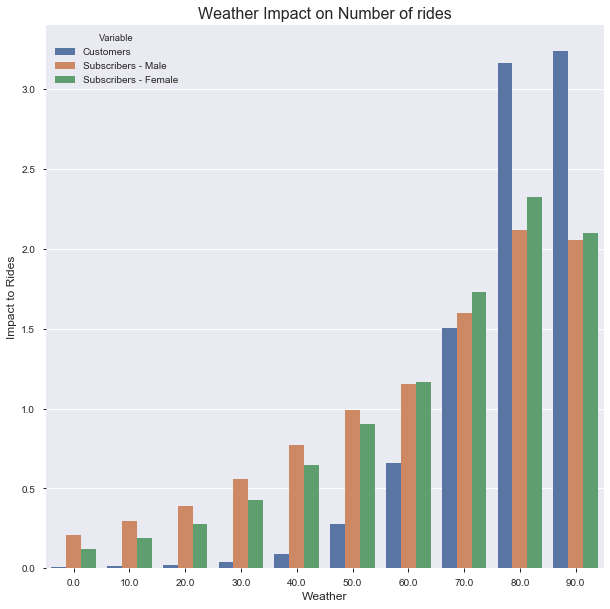

In [100]:
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = percent_all.melt(id_vars='degrees').rename(columns=str.title)

ax1 = sns.barplot(x='Degrees', y='Value', hue='Variable', data=tidy, ax=ax1, palette="deep")
ax1.set_title('Weather Impact on Number of rides', fontsize=16)
ax1.set_xlabel('Weather', fontsize=12)
ax1.set_ylabel('Impact to Rides', fontsize=12)

sns.despine(fig)


Daily Customers
- Are over 3 times more likely to use the bikes >75 °F
- Are 1.5 times more likely to use the bikes between 65 - 75 °F
- Are less likely to use the bikes < 65 °F (trend increasing with decreasing temperature)

Subscribers
- Are over 2 times more likely to use the bikes >75 °F
- Are 1.5 times more likely to use the bikes between 65 - 75 °F
- Are less likely to use the bikes < 45 °F (trend increasing with decreasing temperature)
- Women have a stronger correlation with temperature than men


Next steps:
- look at the effects:
    - Over time (has this behaviour changed over the years)
    - By weather (specifically rain)
    - At hours of the day (commute time for subscribers and weekends for customers)
    - By locations
